## MasterProject SoSe22: "Non-Intrusive Load Monitoring" (NILM)

### Related Work and Backgrounds

- Use publicly available data sets **RAE**, as described by [Makonin et al., 2019] in their paper "RAE: The Rainforest Automation Energy Dataset for Smart Grid Meter Data Analysis".
- Follow general NILM problem description, outlined by [Marwah and Han, 2011] in their paper "Unsupervised Disaggregation of Low Frequency Power Measurements".
- A nice overview of various state-of-the-art techniques used for NILM is found in [Herrero et al., 2018] paper "Non Intrusive Load Monitoring (NILM):A State of the Art", including LSTM models.
- [Herrero et al., 2018] references a PhD Thesis [Kelly, 2017] on "Disaggregation of domestic smart meter energy data": Find in Section 9.4.3 a detailed description of a CNN model.

### Game Plan

#### Data

Decided to work on **RAE data set**. That provides total power consumption and submeter data for two houses. Pick the **first house** in this work and find **24 submeters** and **two sampling periods** of 9 and 63 days, respectively. **Sampling rate is 1Hz**. 

**Idea:** Could use 63 days sample for training before testing the model on the second sample covering 9 days.

#### Problem Statement

Given an aggregate power consumption $Y$ for a total of $T$ time periods:

$$Y = (y_1, y_2,..,y_T)$$

We then want to infer the power load of each of the $M$ appliances for all time steps:

$$ Q^{(1)} = (q^{(1)}_1, q^{(1)}_2,..,q^{(1)}_T) \\
   Q^{(2)} = (q^{(2)}_1, q^{(2)}_2,..,q^{(2)}_T) \\
   ... \\
   Q^{(M)} = (q^{(M)}_1, q^{(M)}_2,..,q^{(M)}_T)
$$

#### Model

There exist various approaches for dissagregation of total power consumption. Here we focus on **deep ANN models** from the domain of **supervised machine learning** techniques. The idea is as follows:

- Feed a sample consisting of a number of time steps of the total power consumption time series as input.
- We use a **sliding window approach** and the appropriate **input length** needs to be specified.
- Later we could extend the model and feed time of the day and/or day of the week as **additional input features**.
- As **target** we have **three scalar values** for each of the $M$ submeters. **Note:** We might not use all submeters or further aggregate certain submeters!
- These three scalar values are **start time, end time and average power consumption for a given submeter** (or aggregate submeters). **Note:** We only predict the *first* usage in the given sample. Details on scaling these three features can be found in Section 9.4.3 of [Kelly, 2017].
- Most promising appears a **CNN/fc model** consisting of one or more CNN layers followd by one or more fully connected (fc) layers with 3 output units. Further details on model setup can also be found in Section 9.4.3 of [Kelly, 2017].
- We then have one (sub-)model for each submeter. Could also try to predict 3 output values for *all* $M$ submeters simultaneously - using $3 \times M$ output units.

#### Data Inspection and Pre-Processing

- **Download data** of both sampling periods for house1 from cloud storage.

For our example house we know not only the aggregate power consumption $Y$ but also power load of each of the $M$ appliances $Q^{(1)},Q^{(2)},..,Q^{(M)}$.

- Create **histogram of appliances' power consumption and ON-durations** as in Figures 2 and 3 of [Marwah and Han, 2011]. 

Expect to find some narrow Gaussian distribution for appliances' power consumption. We could then use mean power consumption for each appliance as a given "steady state feature" and only model ON-durations. However, we will try to predict average power consumption as well, as explained above.

The histogram of ON-durations gives us a feeling for an appropriate input length in our sliding window approach, also explained above.

- Add "time of day" and "day of week" as "non traditional features" from given unix timestamp (= sec passed since Jan 1st, 1970, 00:00h UTC).

Most important pre-processing step is **labelling the submeter time series**:

- Split power load of each of the $M$ appliances into sequences of specified input length.
- Get start time, end time and average power consumption for a given submeter in every sample, scale to [0,1]. **Note:** Only encounter *first* usage in sample, ignore further usages! If submeter is *not* used in sample, all three values are *zero*.

### Tech Preamble

In [1]:
import numpy as np
from os.path import join
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input, Dense, Conv1D, AveragePooling1D, MaxPooling1D, Dropout, Flatten, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.datasets as tfds
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

### Load and inspect Data

In [2]:
## Read input files:

# Have TWO continuous samples covering 9 (data1) and 63 days (data2), respectively.

# Skip header and keep ALL columns: Unix timestamp, some interval total values,
# total power consumption ('main') followed by 24 submeters ('sub1' .. 'sub24').

# Define path to data folder:
path_to_data = "../data"

# Import data from csv files:
data1 = np.genfromtxt(join(path_to_data,'house1_power_blk1.csv'), delimiter=',', skip_header=1)
#data2 = np.genfromtxt(join(path_to_data,'house1_power_blk2.csv'), delimiter=',', skip_header=1)
data2 = data1 # to save time, when only working with data1

In [3]:
# Check dimensions:
print("data1 shape (samples, features): ", data1.shape)
print("data2 shape (samples, features): ", data2.shape)
print("\ndata1 contains ", np.round(data1.shape[0]/ (24*3600),2), " days")
print("data2 contains ", np.round(data2.shape[0]/ (24*3600),2), " days")

data1 shape (samples, features):  (777600, 27)
data2 shape (samples, features):  (777600, 27)

data1 contains  9.0  days
data2 contains  9.0  days


In [4]:
# Check for NaN values in data (main and submeters, only):
print("NaN values in data1: ",np.sum(np.isnan(data1[:,2:])))
print("NaN values in data2: ",np.sum(np.isnan(data2[:,2:])))
print("\nNaN values for main and submeters in data2: \n", np.sum(np.isnan(data2[:,2:]), axis=0)) # 21 sec missing data

NaN values in data1:  0
NaN values in data2:  0

NaN values for main and submeters in data2: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [5]:
# Replace NaN values in data2 by zero:
(data2[:,2:])[np.isnan(data2[:,2:])]=0

In [6]:
## Create labels for 24 submeters in house 1 (copy from house1_labels.txt)

# Numbers of submeters:
labels_num = np.arange(1,25,1)

# Text labels:
labels_long = ['Kitchen Wall Oven L1','Kitchen Wall Oven L2','Kitchen Counter Plugs L1','Kitchen Counter Plugs L2',
               'Clothes Dryer L1','Clothes Dryer L2','Upstairs Bedroom AFCI Arc-Fault Plugs','Kitchen Fridge',
               'Clothes Washer','Kitchen Dishwasher','Furnace & Hot Water Unit (incl. Furnace Room Plug)',
               'Basement Plugs & Lights (incl. Outside Plugs)','Heat Pump L1','Heat Pump L2','Garage Sub-Panel L1',
               'Garage Sub-Panel L2','Upstairs Plugs & Lights L1 (incl. Bathroom Lights and Vent Fan, Smoke Alarms, Living Room Plugs)',
               'Upstairs Plugs & Lights L2 (incl. Bathroom Lights and Vent Fan, Smoke Alarms, Living Room Plugs)',
               'Basement Blue Plugs (incl. Ent. TV/Amp/DVD/PVR)','Bathrooms (incl. 3 GFCI Plugs, 2 Lights, 1 Vent Fan, Chest Freezer)',
               'Rental Suite Sub-Panel L1','Rental Suite Sub-Panel L2','Misc. Plugs (incl. Dining Room, Gas Cooktop, Microwave)',
               'Home Office (incl. Telco/Cable/Net/Security Equip.)']

In [7]:
## Try to reproduce plot of all loads for one day for house 1, as in [Makonin et al., 2019]:
## Note: stackplot needs transposed data!

# Create time axis for one day:
time = range(24*3600)

# Transpose submeter data, need to skip first three columns (Unix timestamp, some interval total values,
# total power consumption ('main')):
data1_transp = np.transpose(data1[:,3:])
data2_transp = np.transpose(data2[:,3:])

# Extract first day from first sample (covering 9 days in total):
data1_transp_d1 = data1_transp[:,:24*3600]

In [8]:
## Further aggregate submeters to end up with 10 classes:

# Initialize storage for aggregate transposed submeter data:
data1_transp_agg = np.zeros((10,len(data1)))
data2_transp_agg = np.zeros((10,len(data2)))

## Manually aggragate submeters, as in [Makonin et al. 2019]:

# Garage: Submeters 15, 16
data1_transp_agg[0] = data1_transp[14] + data1_transp[15]
data2_transp_agg[0] = data2_transp[14] + data2_transp[15]

# Clothes Dryer: Submeters 5, 6
data1_transp_agg[1] = data1_transp[4] + data1_transp[5]
data2_transp_agg[1] = data2_transp[4] + data2_transp[5]

# HVAC & Heat Pump: Submeters 11, 13, 14
data1_transp_agg[2] = data1_transp[10] + data1_transp[12] + data1_transp[13]
data2_transp_agg[2] = data2_transp[10] + data2_transp[12] + data2_transp[13]

# Rental Suite: Submeters 21, 22
data1_transp_agg[3] = data1_transp[20] + data1_transp[21]
data2_transp_agg[3] = data2_transp[20] + data2_transp[21]

# Plugs & Lights: Submeters 3, 4, 7, 12, 17, 18, 19, 20, 23
data1_transp_agg[4] = data1_transp[2] + data1_transp[3] + data1_transp[6] + data1_transp[11] + data1_transp[16] + data1_transp[17] + data1_transp[18] + data1_transp[19] + data1_transp[22]
data2_transp_agg[4] = data2_transp[2] + data2_transp[3] + data2_transp[6] + data2_transp[11] + data2_transp[16] + data2_transp[17] + data2_transp[18] + data2_transp[19] + data2_transp[22]

# Wall Oven: Submeters 1, 2
data1_transp_agg[5] = data1_transp[0] + data1_transp[1]
data2_transp_agg[5] = data2_transp[0] + data2_transp[1]

# Fridge: Submeter 8
data1_transp_agg[6] = data1_transp[7]
data2_transp_agg[6] = data2_transp[7]

# Clothes Washer: Submeter 9
data1_transp_agg[7] = data1_transp[8]
data2_transp_agg[7] = data2_transp[8]

# Dish Washer: Submeter 10
data1_transp_agg[8] = data1_transp[9]
data2_transp_agg[8] = data2_transp[9]

# Home Office: Submeter 24
data1_transp_agg[9] = data1_transp[23]
data2_transp_agg[9] = data2_transp[23]

## Create labels for aggregate submeters:
labels_long_agg = ['Garage','Clothes Dryer','HVAC & Heat Pump','Rental Suite','Plugs & Lights','Wall Oven',
                   'Fridge','Clothes Washer','Dish Washer','Home Office']

In [9]:
# Plausibility Check: Sum of aggregated submeters must equal total energy consumption in raw data. 
# Expect zero difference!
print("plausi check sample 1 (expect 0.0): ", np.sum(np.sum(data1_transp_agg,axis=0)-data1[:,2]))
print("plausi check sample 2 (expect 0.0): ", np.sum(np.sum(data2_transp_agg,axis=0)-data2[:,2]))

plausi check sample 1 (expect 0.0):  0.0
plausi check sample 2 (expect 0.0):  0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Power [W]')

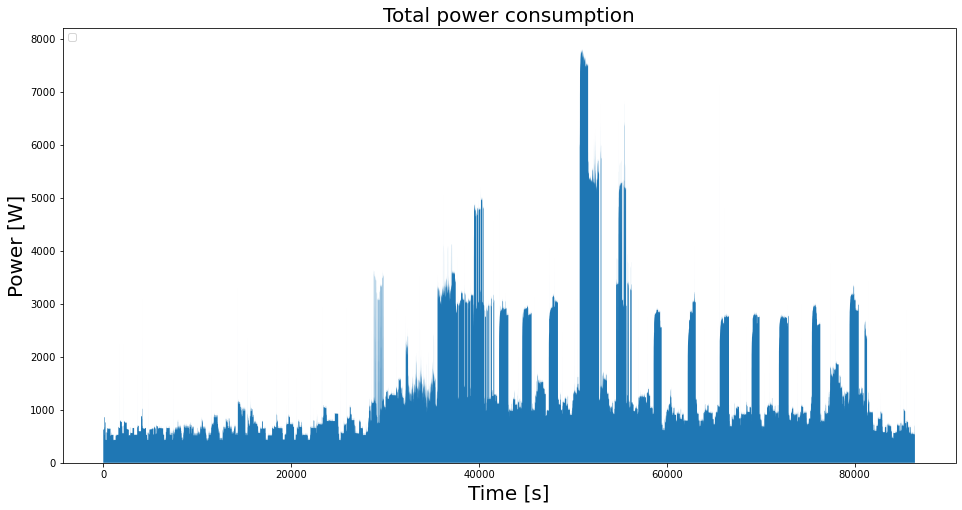

In [10]:
# Plot total power consumption from aggregate submeter data for first day from first sample:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(time, np.sum(data1_transp_agg,axis=0)[:24*3600])
plt.legend(loc='upper left')
plt.title('Total power consumption', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

Text(0, 0.5, 'Power [W]')

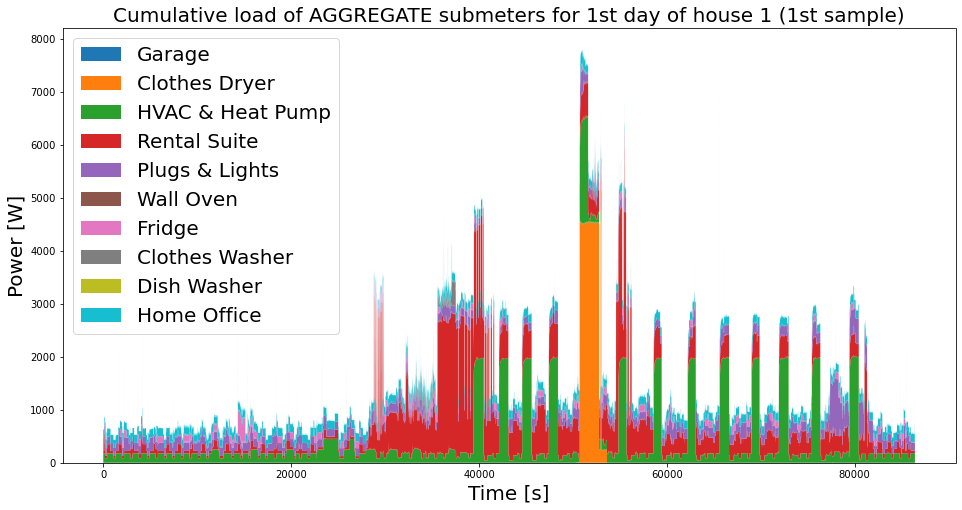

In [11]:
# Plot aggregate submeter data for first day from first sample:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(time, data1_transp_agg[:,:24*3600], labels=labels_long_agg)
plt.legend(loc='upper left', fontsize=20)
plt.title('Cumulative load of AGGREGATE submeters for 1st day of house 1 (1st sample)', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Power [W]')

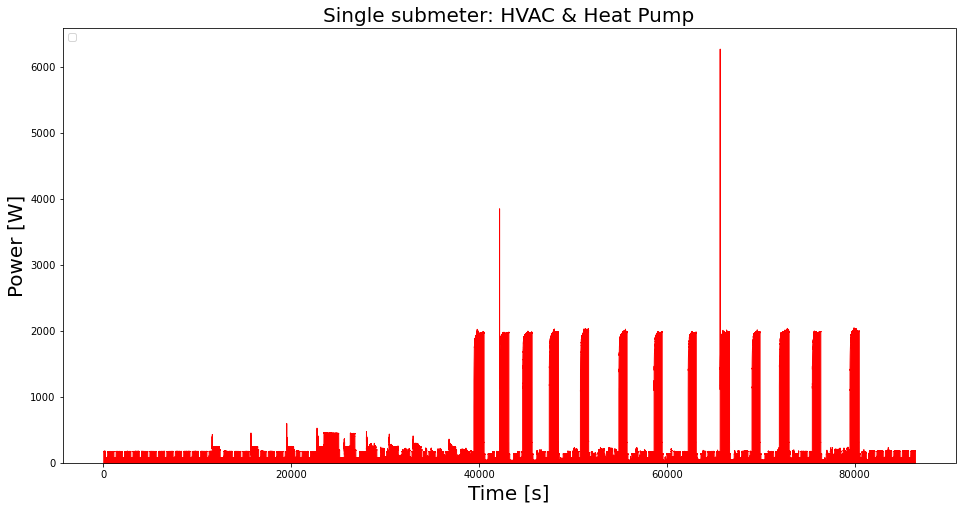

In [12]:
# Plot "HVAC & Heat Pump" from aggregated submeter data for first day from first sample:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(time, data1_transp_agg[2,:24*3600], color="red")
plt.legend(loc='upper left')
plt.title('Single submeter: HVAC & Heat Pump', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

Text(0, 0.5, 'Power [W]')

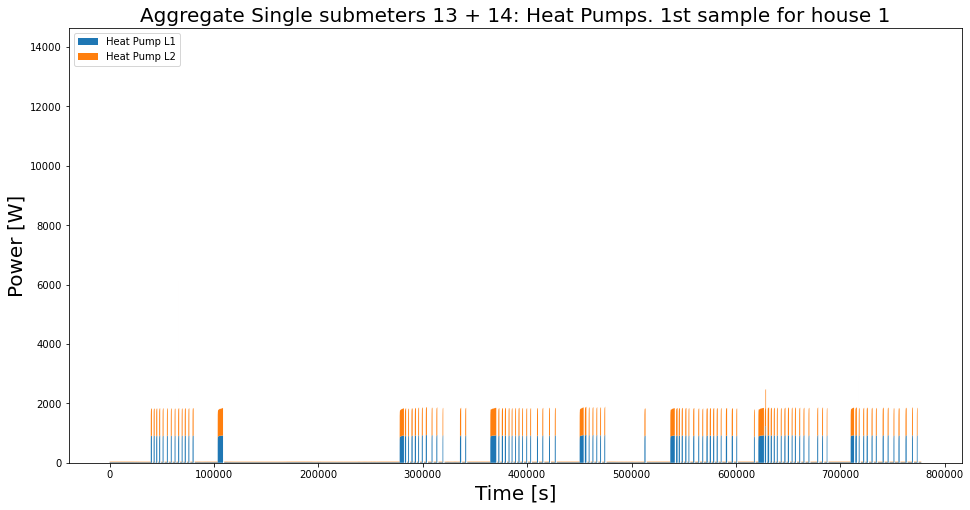

In [13]:
# Aggregate power load for Heat Pumps: Whole time span of first sample (9 days) for house1    
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(range(data1_transp.shape[1]), data1_transp[12:14,:], labels=labels_long[12:14])
plt.legend(loc='upper left')
plt.title('Aggregate Single submeters 13 + 14: Heat Pumps. 1st sample for house 1', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

In [14]:
## Decision after inspection:

## Continue only with following submeters:
# 4 Kitchen Counter Plugs L2: Seem to have nice noise-less pattern.
# 5 + 6 Clothes dryer L1 + L2: Could be aggregated, have similar ON/OFF times pattern.
# 8 Fridge: Needed to zoom in to see nice pattern on shorter time scales, compared to e.g. dishwasher
# 9 Clothes washer
# 10 Dish Washer
# 13 + 14 Heat Pumps: Could be aggregated, have similar ON/OFF times pattern.

## Ignore the rest for now: Either too noisy / irregular (plugs / home office), or avg. load close to zero or 
## in aggregated form (rental suite).
## But with above selection we should already cover quite some significant portion of total power load!

# And keep in mind: We still use the total power load signial including ALL submeters as input signal!

In [15]:
### NEXT: Start with aggregated Heat Pumps as Prototype

# Define noise level and delay time. 
# Get labels
# [Plot histogram of avg use during ON periods]
# [Plot histogram of ON durations]
# Derive reasonable input length T
# Split data
# Scale Start Time, End Time, Avg Power Load to [0,1]
# CNN / fc model
# Post-processing: Restore time series with predicted power load from predicted start/end times
# Performance Measures

In [16]:
## Extract input series for samples 1 and 2 from data: Total Power Load.
## Remember: Total Power Load is third column in data!
inputs1 = data1[:,2]
inputs2 = data2[:,2]

In [17]:
## Extract and aggregate target series for samples 1 and 2 from data: Heat pumps (subm 13 + 14).
## Remember: Submeters 13 + 14 are columns 16 + 17 in data
target1 = np.sum(data1[:,15:17], axis=1)
target2 = np.sum(data2[:,15:17], axis=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Power [W]')

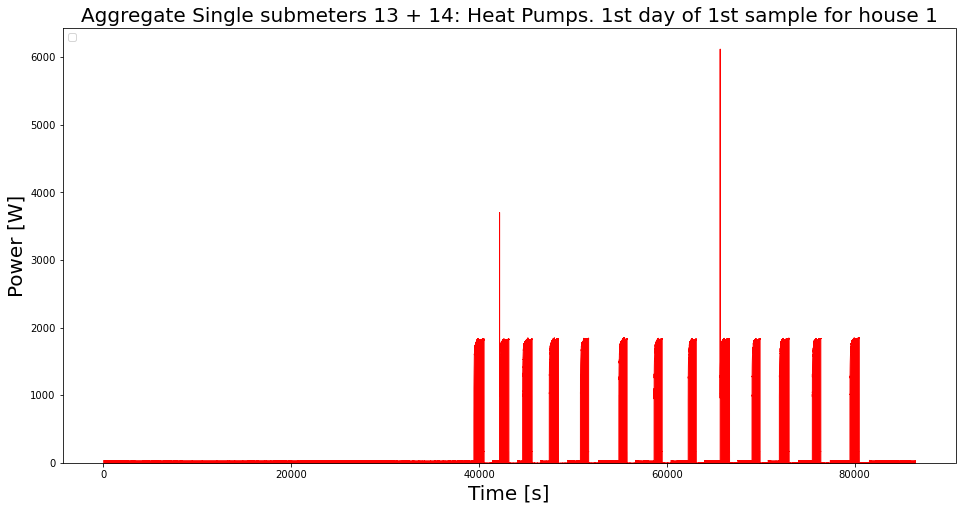

In [18]:
## Try to define noise level by visual inspection first:

# Plot Heat pumps in aggregated form from submeter data 13 + 14 for first day from first sample:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(time, target1[:24*3600], color="red")
plt.legend(loc='upper left')
plt.title('Aggregate Single submeters 13 + 14: Heat Pumps. 1st day of 1st sample for house 1', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

In [19]:
## Looks like constant "stand-by" power load during OFF times:
target1[:10]

array([38., 38., 38., 38., 38., 38., 38., 38., 38., 38.])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Power [W]')

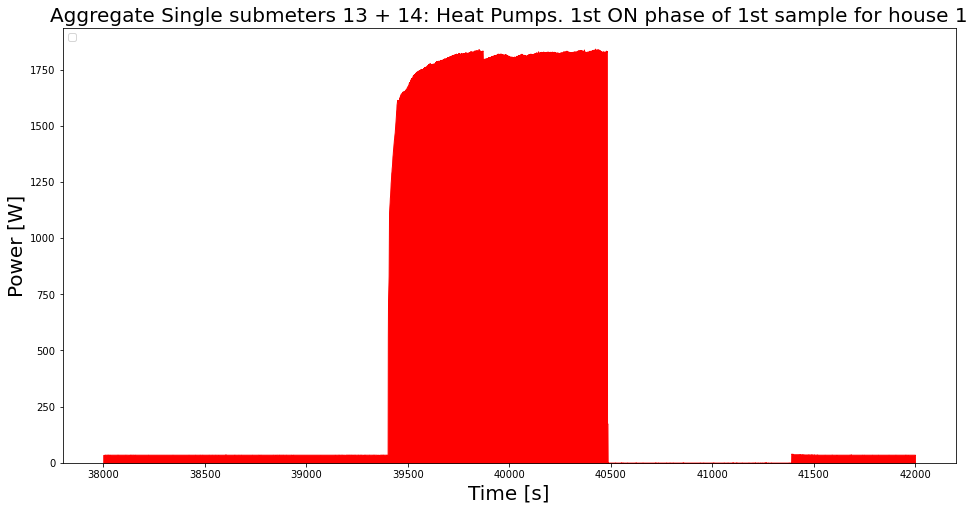

In [20]:
## Zoom into first ON phase, to see if power load unexpectedly drops to zero during ON phase:

# Plot Heat pumps in aggregated form from submeter data 13 + 14 for first usage from first sample:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(np.arange(38000,42000,1), target1[38000:42000], color="red")
plt.legend(loc='upper left')
plt.title('Aggregate Single submeters 13 + 14: Heat Pumps. 1st ON phase of 1st sample for house 1', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

In [21]:
## Set noise level and delay time.
## "Delay time" means, that power load is allowed to drop below noise level during ON phase for a specified
## number of seconds. If drop exceeds delay time, we assume the appliance to be switched OFF again.

# Noise level of 50 Watt seems to be sufficient, since "stand-by" load appears to be constantly at 38 Watt.
noise_level = 50

# There seem to be no unexpected drops in power load during ON phase. 
delay_time = 0

In [22]:
# Now create new binary series containing 1 (= ON) and 0 (= OFF), respecting specified noise level:
target1_ON_OFF = (target1 > noise_level).astype(int)

# Get power load during ON times:
target1_load = target1 * target1_ON_OFF

# Get mean power load from load during ON times as single value:
target1_mean_load = np.mean(target1_load[target1_load>0])

# Get mean load during ON times as time series:
target1_mean_load_series = target1_mean_load * target1_ON_OFF

# Check avg usage time and mean load during ON times:
print("avg usage: ", np.round(np.sum(target1_ON_OFF) / len(target1) * 100, 2), "%")
print("mean load during ON times: ", np.round(target1_mean_load,2), "W")

avg usage:  15.79 %
mean load during ON times:  1800.22 W


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Power [W]')

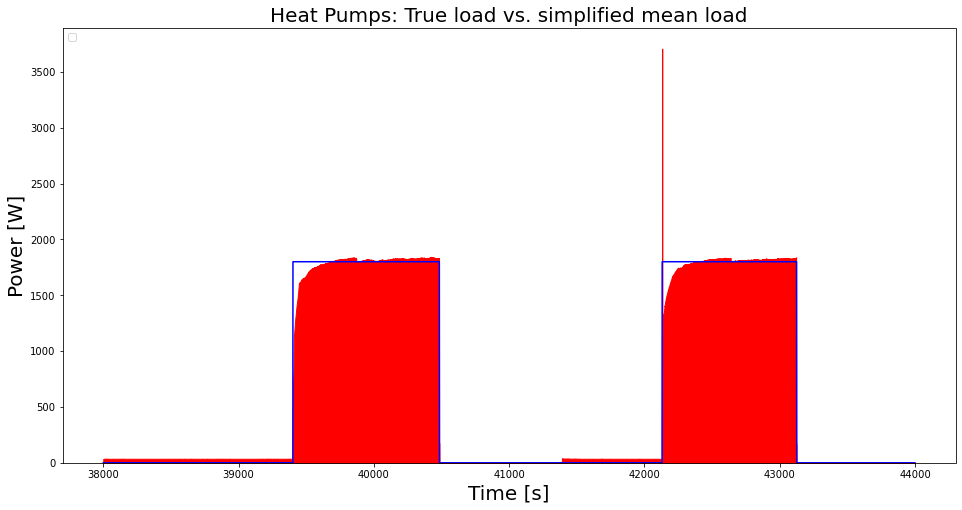

In [23]:
# Plot true load for heat pumps (aggregated) vs. simplified mean load for
# first two ON phases from 1st sample for house1:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(np.arange(38000,44000,1), target1[38000:44000], color="red")
ax.plot(np.arange(38000,44000,1), target1_mean_load_series[38000:44000], color="blue")
plt.legend(loc='upper left')
plt.title('Heat Pumps: True load vs. simplified mean load', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

In [24]:
## Prepare labelling:

## Get switching events from binary ON_OFF series:
## Shift series by one time step and subtract original series.
## This gives us +1 for switchen ON and -1 for switching OFF.
target1_switch_events = target1_ON_OFF[1:] - target1_ON_OFF[:-1]

## But this requires adding a ZERO as first element, to keep dimensions correct:
target1_switch_events = np.insert(target1_switch_events,0,np.array([0]))

## Now get separate series for start and end times from switching event series:
target1_start_time = (target1_switch_events==1).astype(int)
target1_end_time = (target1_switch_events==-1).astype(int)

## Check dimensions and number of switching events:
print("switch events series shape (time steps): ", np.shape(target1_switch_events))
print("start_time series shape (time steps): ", np.shape(target1_start_time))
print("end_time series shape (time steps): ", np.shape(target1_end_time))
print("number of ON switch events: ", np.sum(target1_switch_events==1))
print("number of OFF switch events: ", np.sum(target1_switch_events==-1))
print("\ninputs1 shape (time steps, features): ", inputs1.shape)

switch events series shape (time steps):  (777600,)
start_time series shape (time steps):  (777600,)
end_time series shape (time steps):  (777600,)
number of ON switch events:  99
number of OFF switch events:  99

inputs1 shape (time steps, features):  (777600,)


In [25]:
# Get mean ON duration:
target1_ON_time = sum(target1_ON_OFF>0)
print("mean ON duration: ", np.round(target1_ON_time / np.sum(target1_switch_events==1),0), "sec")

mean ON duration:  1241.0 sec


In [26]:
# Define function to split time series 'sequence' into 'n_steps'
def split_sequence(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)

In [27]:
# Specify input length: Take a bit more than half of the mean ON duration
input_length = 700

# Split inputs and targets into sequences of specified length:
inputs1_split = split_sequence(inputs1, input_length)
target1_start_time_split = split_sequence(target1_start_time, input_length)
target1_end_time_split = split_sequence(target1_end_time, input_length)

# Check dimensions:
print("inputs1_split shape (samples, time steps, in features): ", np.shape(inputs1_split))
print("target1_start_time_split shape (samples, time steps, out features): ", np.shape(target1_start_time_split))
print("target1_end_time_split shape (samples, time steps, out features): ", np.shape(target1_end_time_split))

inputs1_split shape (samples, time steps, in features):  (776901, 700)
target1_start_time_split shape (samples, time steps, out features):  (776901, 700)
target1_end_time_split shape (samples, time steps, out features):  (776901, 700)


In [28]:
# Now have target samples as sequences, for both start time and end time.
# Need to convert to single target values, which shall be the position of the FIRST switching event (ON or OFF)
# relative to sequence length, hence a value in [0,1], where 0.5 refers to an event in the middle of input_length.
# If NO event is present in a sample, target value shall be ZERO.

# Initialize storage for target values: Position of start and end time
target1_start_time_pos = np.zeros((len(target1_start_time_split), 1))
target1_end_time_pos = np.zeros((len(target1_end_time_split), 1))

# Loop over target samples: Start time
for i in range(len(target1_start_time_split)):
    
    # Get current sample:
    sample = target1_start_time_split[i]
    
    # Look for non-zero values in current sample. Resulting shape is [1, num_of_occurences]. Use that in if clause:
    if np.array(np.nonzero(sample)).shape[1] > 0:
        
        # Store relative position of FIRST switching event:
        target1_start_time_pos[i] = (np.array(np.nonzero(sample))[0,0] + 1) / input_length
        
# Loop over target samples: End time
for i in range(len(target1_end_time_split)):
    
    # Get current sample:
    sample = target1_end_time_split[i]
    
    # Look for non-zero values in current sample. Resulting shape is [1, num_of_occurences]. Use that in if clause:
    if np.array(np.nonzero(sample)).shape[1] > 0:
        
        # Store relative position of FIRST switching event:
        target1_end_time_pos[i] = (np.array(np.nonzero(sample))[0,0] + 1) / input_length
        

In [29]:
# Reshape inputs (total power load) to have feature as third dimension:
inputs1_split_reshape = np.reshape(inputs1_split, (len(inputs1_split), input_length, 1))

# Concatenate targets: Position of start and end time
targets1_concat = np.concatenate([target1_start_time_pos, target1_end_time_pos], axis=1)

# Check dimensions:
print("inputs1_split_reshape shape (samples, time steps, in features): ", inputs1_split_reshape.shape)
print("targets1_concat shape (samples, out features): ", targets1_concat.shape)

inputs1_split_reshape shape (samples, time steps, in features):  (776901, 700, 1)
targets1_concat shape (samples, out features):  (776901, 2)


In [30]:
## Scale inputs (total power load) to [0,1] with min-max scaling:

# Get min / max:
input1_min = np.min(inputs1_split_reshape)
input1_max = np.max(inputs1_split_reshape)

# Scale:
inputs1_split_reshape_scaled = (inputs1_split_reshape - input1_min) / (input1_max - input1_min)

# Check scaling:
print("min BEFORE scaling: ", input1_min)
print("max BEFORE scaling: ", input1_max)
print("\nmin AFTER scaling: ", np.min(inputs1_split_reshape_scaled))
print("max AFTER scaling: ", np.max(inputs1_split_reshape_scaled))

min BEFORE scaling:  344.0
max BEFORE scaling:  18115.0

min AFTER scaling:  0.0
max AFTER scaling:  1.0


In [31]:
## Split inputs and targets into train and validation sets:

# Get number of train samples: 80% of ALL samples
n_train = int(0.8 * len(inputs1_split_reshape_scaled))

# Split:
train_input = inputs1_split_reshape_scaled[:n_train]
val_input = inputs1_split_reshape_scaled[n_train:]
train_target = targets1_concat[:n_train]
val_target = targets1_concat[n_train:]

## Dimension check:
print("train inputs (samples, time steps): ", train_input.shape)
print("val inputs (samples, time steps): ", val_input.shape)
print("\ntrain targets (samples, time steps, features): ", train_target.shape)
print("val targets (samples, time steps, features): ", val_target.shape)

train inputs (samples, time steps):  (621520, 700, 1)
val inputs (samples, time steps):  (155381, 700, 1)

train targets (samples, time steps, features):  (621520, 2)
val targets (samples, time steps, features):  (155381, 2)


### Disaggregation using CNN network

Inspired by [Kelly, 2017] try to develop some CNN / fc model.

Keep it very simple for the beginning: 

- Use total power load as **input** series, scaled to [0,1].
- Use relative position of FIRST start and end time as **targets**.
- Assume mean load during ON phases as constant for now. Could be used as *third* target value later!

In [244]:
## Set up simple CNN model
model = Sequential()
model.add(Conv1D(input_shape=(input_length, 1), filters=16, kernel_size=10, strides=1, activation='relu'))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Conv1D(filters=16, kernel_size=10, strides=1, activation='relu'))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Flatten())
model.add(Dense(units=1024, activation = 'relu'))
model.add(Dense(units=512, activation = 'relu'))
model.add(Dense(units=128, activation = 'relu'))
model.add(Dense(units=2, activation = 'relu'))

# Get model summary:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 691, 16)           176       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 345, 16)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 336, 16)           2576      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 168, 16)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2688)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              2753536   
_________________________________________________________________
dense_13 (Dense)             (None, 512)              

In [245]:
# Set number of epochs, batch size and learning rate:
n_epochs = 5
batch_size = 100 # 100
learning_rate=0.0001 # 0.0001

# Compile model:
model.compile(optimizer=Adam(learning_rate=learning_rate),loss='mse')

In [246]:
# Train model:
history = model.fit(train_input, train_target, epochs=n_epochs, batch_size=batch_size, verbose=1, validation_data=(val_input, val_target))

Epoch 1/5
6216/6216 [==============================] - 427s 69ms/step - loss: 0.0056 - val_loss: 0.0117
Epoch 2/5
6216/6216 [==============================] - 419s 67ms/step - loss: 0.0015 - val_loss: 0.0105
Epoch 3/5
6216/6216 [==============================] - 413s 67ms/step - loss: 8.2965e-04 - val_loss: 0.0122
Epoch 4/5
6216/6216 [==============================] - 407s 65ms/step - loss: 5.9974e-04 - val_loss: 0.0123
Epoch 5/5
6216/6216 [==============================] - 408s 66ms/step - loss: 4.3741e-04 - val_loss: 0.0115


In [257]:
## Save trained model:
path_to_model = '../models/heat_pump_large'
#model.save(path_to_model)

## Reload trained model:
#model = tf.keras.models.load_model(path_to_model)

INFO:tensorflow:Assets written to: ../models/heat_pump_large/assets


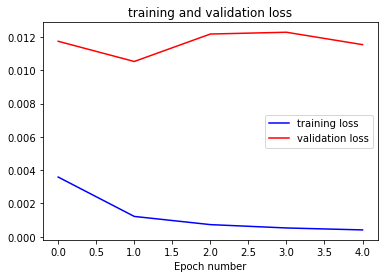

In [247]:
# Plot train and val_loss: Mean squared error
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
plt.title('training and validation loss')
plt.legend()
plt.show()  

In [258]:
## Get model predictions:
#train_pred = model.predict(train_input)
val_pred = model.predict(val_input)
train_pred = model.predict(train_input)

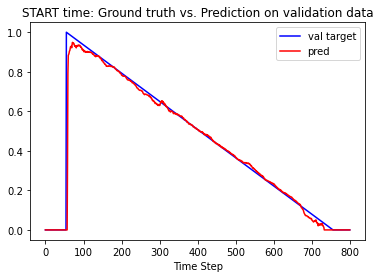

In [249]:
# Fidelity check: Plot predicted START time vs. target for on event in validation data
plt.plot(val_target[5400:6200,0], color = 'blue', label = 'val target')
plt.plot(val_pred[5400:6200,0], color = 'red', label = 'pred')
plt.xlabel('Time Step')
plt.title('START time: Ground truth vs. Prediction on validation data')
plt.legend()
plt.show()

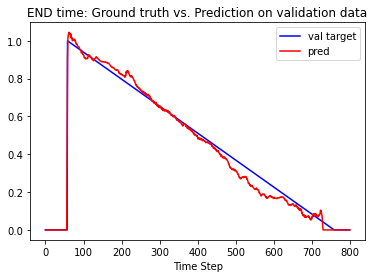

In [250]:
# Fidelity check: Plot predicted END time vs. target for on event in validation data
plt.plot(val_target[6600:7400,1], color = 'blue', label = 'val target')
plt.plot(val_pred[6600:7400,1], color = 'red', label = 'pred')
plt.xlabel('Time Step')
plt.title('END time: Ground truth vs. Prediction on validation data')
plt.legend()
plt.show()

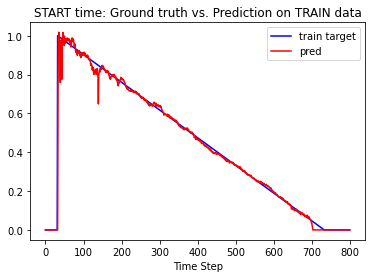

In [259]:
# Fidelity check: Plot predicted START time vs. target for on event in TRAIN data
plt.plot(train_target[41400:42200,0], color = 'blue', label = 'train target')
plt.plot(train_pred[41400:42200,0], color = 'red', label = 'pred')
plt.xlabel('Time Step')
plt.title('START time: Ground truth vs. Prediction on TRAIN data')
plt.legend()
plt.show()

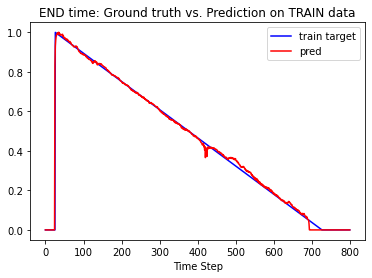

In [260]:
# Fidelity check: Plot predicted END time vs. target for on event in TRAIN data
plt.plot(train_target[42400:43200,1], color = 'blue', label = 'train target')
plt.plot(train_pred[42400:43200,1], color = 'red', label = 'pred')
plt.xlabel('Time Step')
plt.title('END time: Ground truth vs. Prediction on TRAIN data')
plt.legend()
plt.show()

In [261]:
## In our sliding window approach we have input_length overlapping samples for each time step.
## Only pick every input_length's target, to avoid overlap:
val_target_plain = val_target[np.arange(0,len(val_target),input_length)]
val_pred_plain = val_pred[np.arange(0,len(val_pred),input_length)]
train_target_plain = train_target[np.arange(0,len(train_target),input_length)]
train_pred_plain = train_pred[np.arange(0,len(train_pred),input_length)]

# Check dimensions and number of events:
print("val_target shape WITHOUT overlap: ", val_target_plain.shape)
print("val_pred shape WITHOUT overlap: ", val_pred_plain.shape)
print("val_target: number of ON switching events: ", np.sum((val_target_plain[:,0]!=0)))
print("val_target: number of OFF switching events: ", np.sum((val_target_plain[:,1]!=0)))
print("val_pred: number of ON switching events: ", np.sum((val_pred_plain[:,0]!=0)))
print("val_pred: number of OFF switching events: ", np.sum((val_pred_plain[:,1]!=0)))

print("\ntrain_target shape WITHOUT overlap: ", train_target_plain.shape)
print("train_pred shape WITHOUT overlap: ", train_pred_plain.shape)
print("train_target: number of ON switching events: ", np.sum((train_target_plain[:,0]!=0)))
print("train_target: number of OFF switching events: ", np.sum((train_target_plain[:,1]!=0)))
print("train_pred: number of ON switching events: ", np.sum((train_pred_plain[:,0]!=0)))
print("train_pred: number of OFF switching events: ", np.sum((train_pred_plain[:,1]!=0)))

val_target shape WITHOUT overlap:  (222, 2)
val_pred shape WITHOUT overlap:  (222, 2)
val_target: number of ON switching events:  30
val_target: number of OFF switching events:  31
val_pred: number of ON switching events:  31
val_pred: number of OFF switching events:  31

train_target shape WITHOUT overlap:  (888, 2)
train_pred shape WITHOUT overlap:  (888, 2)
train_target: number of ON switching events:  69
train_target: number of OFF switching events:  68
train_pred: number of ON switching events:  67
train_pred: number of OFF switching events:  75


In [262]:
### Restore appliance's power load from plain targets and predictions:

## First restore start and end times:

## Validation data:

# Initialize storage:
val_target_plain_start = np.zeros(len(val_target_plain) * input_length)
val_target_plain_end = np.zeros(len(val_target_plain) * input_length)
val_pred_plain_start = np.zeros(len(val_pred_plain) * input_length)
val_pred_plain_end = np.zeros(len(val_pred_plain) * input_length)

# Loop over plain target:
for i in range(len(val_target_plain)):
    
    # Check for non-zero start and end time, given as relative position in sample. 
    # Need to multiply with input_length, to restore absolute position.
    start_time_abs = int(val_target_plain[i,0] * input_length)
    end_time_abs = int(val_target_plain[i,1] * input_length)
    
    # Store start time for i-th sample, ONLY if start_time is non-zero:
    if start_time_abs != 0:
        val_target_plain_start[(i * input_length) + start_time_abs - 1] = 1
    
    # Store end time for i-th sample, ONLY if start_time is non-zero:
    if end_time_abs != 0:
        val_target_plain_end[(i * input_length) + end_time_abs - 1] = 1
        
        
# Loop over plain pred:
for i in range(len(val_pred_plain)):
    
    # Check for non-zero start and end time, given as relative position in sample. 
    # Need to multiply with input_length, to restore absolute position.
    start_time_abs = int(val_pred_plain[i,0] * input_length)
    end_time_abs = int(val_pred_plain[i,1] * input_length)
    
    # Store start time for i-th sample, ONLY if start_time is non-zero:
    if start_time_abs != 0:
        val_pred_plain_start[(i * input_length) + start_time_abs - 1] = 1
    
    # Store end time for i-th sample, ONLY if start_time is non-zero:
    if end_time_abs != 0:
        val_pred_plain_end[(i * input_length) + end_time_abs - 1] = 1

        
## Train data:

# Initialize storage:
train_target_plain_start = np.zeros(len(train_target_plain) * input_length)
train_target_plain_end = np.zeros(len(train_target_plain) * input_length)
train_pred_plain_start = np.zeros(len(train_pred_plain) * input_length)
train_pred_plain_end = np.zeros(len(train_pred_plain) * input_length)

# Loop over plain target:
for i in range(len(train_target_plain)):
    
    # Check for non-zero start and end time, given as relative position in sample. 
    # Need to multiply with input_length, to restore absolute position.
    start_time_abs = int(train_target_plain[i,0] * input_length)
    end_time_abs = int(train_target_plain[i,1] * input_length)
    
    # Store start time for i-th sample, ONLY if start_time is non-zero:
    if start_time_abs != 0:
        train_target_plain_start[(i * input_length) + start_time_abs - 1] = 1
    
    # Store end time for i-th sample, ONLY if start_time is non-zero:
    if end_time_abs != 0:
        train_target_plain_end[(i * input_length) + end_time_abs - 1] = 1
        
        
# Loop over plain pred:
for i in range(len(train_pred_plain)):
    
    # Check for non-zero start and end time, given as relative position in sample. 
    # Need to multiply with input_length, to restore absolute position.
    start_time_abs = int(train_pred_plain[i,0] * input_length)
    end_time_abs = int(train_pred_plain[i,1] * input_length)
    
    # Store start time for i-th sample, ONLY if start_time is non-zero:
    if start_time_abs != 0:
        train_pred_plain_start[(i * input_length) + start_time_abs - 1] = 1
    
    # Store end time for i-th sample, ONLY if start_time is non-zero:
    if end_time_abs != 0:
        train_pred_plain_end[(i * input_length) + end_time_abs - 1] = 1



In [263]:
### Then restore power load from restored start and end times:


## Val Target:

# Combine start and end times to one series containing switching events: ON = 1, OFF = -1
val_target_plain_ON_OFF = val_target_plain_start - val_target_plain_end

# Initialize storage:
val_target_plain_load = np.zeros(len(val_target_plain) * input_length)

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(val_target_plain_ON_OFF)):
    
    # First time step:
    if i == 0:
        val_target_plain_load[i] = np.max([0, val_target_plain_ON_OFF[i]])
    else:
        val_target_plain_load[i] = np.min([1, np.max([0, val_target_plain_load[i-1] + val_target_plain_ON_OFF[i]])])

# And finally multiply load series with target1_mean_load:
val_target_plain_load = val_target_plain_load * target1_mean_load


## Val Pred:

# Combine start and end times to one series containing switching events: ON = 1, OFF = -1
val_pred_plain_ON_OFF = val_pred_plain_start - val_pred_plain_end

# Initialize storage:
val_pred_plain_load = np.zeros(len(val_pred_plain) * input_length)

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(val_pred_plain_ON_OFF)):
    
    # First time step:
    if i == 0:
        val_pred_plain_load[i] = np.max([0, val_pred_plain_ON_OFF[i]])
    else:
        val_pred_plain_load[i] = np.min([1, np.max([0, val_pred_plain_load[i-1] + val_pred_plain_ON_OFF[i]])])

# And finally multiply load series with target1_mean_load:
val_pred_plain_load = val_pred_plain_load * target1_mean_load


## Train Target:

# Combine start and end times to one series containing switching events: ON = 1, OFF = -1
train_target_plain_ON_OFF = train_target_plain_start - train_target_plain_end

# Initialize storage:
train_target_plain_load = np.zeros(len(train_target_plain) * input_length)

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(train_target_plain_ON_OFF)):
    
    # First time step:
    if i == 0:
        train_target_plain_load[i] = np.max([0, train_target_plain_ON_OFF[i]])
    else:
        train_target_plain_load[i] = np.min([1, np.max([0, train_target_plain_load[i-1] + train_target_plain_ON_OFF[i]])])

# And finally multiply load series with target1_mean_load:
train_target_plain_load = train_target_plain_load * target1_mean_load


## Train Pred:

# Combine start and end times to one series containing switching events: ON = 1, OFF = -1
train_pred_plain_ON_OFF = train_pred_plain_start - train_pred_plain_end

# Initialize storage:
train_pred_plain_load = np.zeros(len(train_pred_plain) * input_length)

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(train_pred_plain_ON_OFF)):
    
    # First time step:
    if i == 0:
        train_pred_plain_load[i] = np.max([0, train_pred_plain_ON_OFF[i]])
    else:
        train_pred_plain_load[i] = np.min([1, np.max([0, train_pred_plain_load[i-1] + train_pred_plain_ON_OFF[i]])])

# And finally multiply load series with target1_mean_load:
train_pred_plain_load = train_pred_plain_load * target1_mean_load

Text(0, 0.5, 'Power [W]')

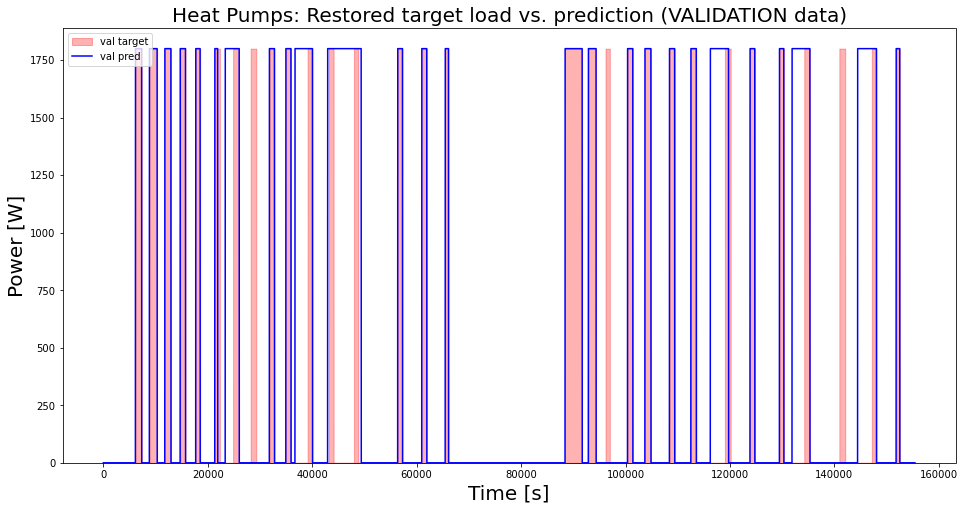

In [266]:
# Plot restored target load for heat pumps (aggregated) vs. restored prediction on VALIDATION data
# from 1st sample for house1:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(range(len(val_target_plain_load)), val_target_plain_load, color="red", alpha=0.3, labels=['val target'])
ax.plot(val_pred_plain_load, color="blue", label='val pred')
plt.legend(loc='upper left')
plt.title('Heat Pumps: Restored target load vs. prediction (VALIDATION data)', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

Text(0, 0.5, 'Power [W]')

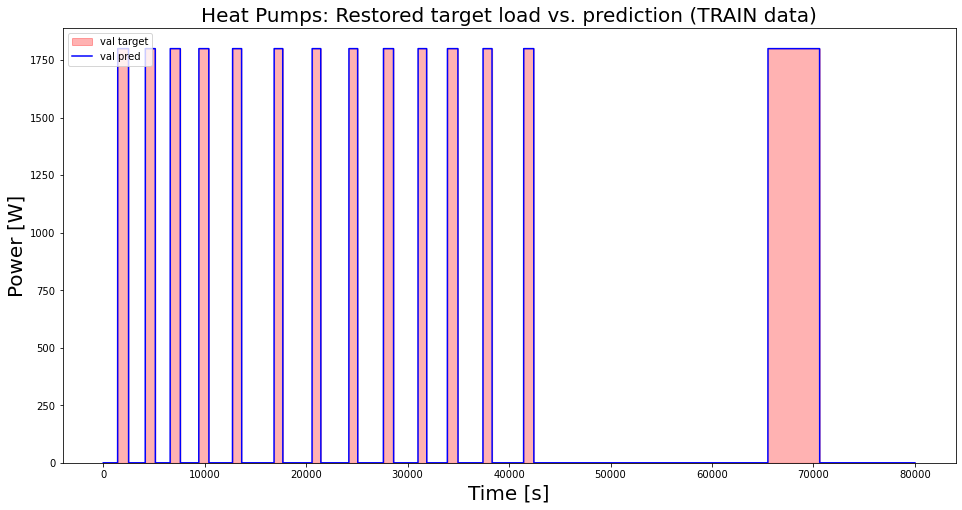

In [267]:
# Plot restored target load for heat pumps (aggregated) vs. restored prediction on TRAIN data
# from 1st sample for house1:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(range(len(train_target_plain_load[38000:118000])), train_target_plain_load[38000:118000], color="red", alpha=0.3, labels=['val target'])
ax.plot(train_pred_plain_load[38000:118000], color="blue", label='val pred')
plt.legend(loc='upper left')
plt.title('Heat Pumps: Restored target load vs. prediction (TRAIN data)', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

### Model Evaluation

[Marwah and Han, 2011] describe **Precision, Recall and F-measure** as some metrics used for evaluation of our models' performance: Let $x$ be the predicted value and $x_0$ to be the ground truth. In our case we look at power consumption of a certain appliance at a certain time step. We then need to distinguish:

$$
x=0\,\,\,AND\,\,\,x_0=0\,\,\,\,\,\,\rightarrow TN \\
x=0\,\,\,AND\,\,\,x_0>0\,\,\,\,\,\,\rightarrow FN \\
x>0\,\,\,AND\,\,\,x_0=0\,\,\,\,\,\,\rightarrow FP \\
x>0\,\,\,AND\,\,\,x_0>0\,\,\,\,\,\,\rightarrow TP 
$$

Here TN, FN, FP and TP refer to "true negative", "false negative", "false positive" and "true positive", respectively. TP is then further split into "inaccurate true positive" (ITP) and "accurate true positive" (ATP), given $\frac{|x-x_0|}{x_0}>\rho$ or $\frac{|x-x_0|}{x_0}\leq\rho$, respectively, with some threshhold $\rho=0.2$.

We then define **Precision**=$\frac{ATP}{ATP + ITP + FP}$, **Recall**=$\frac{ATP}{ATP + ITP + FN}$ and **F-measure**=$\frac{2 \cdot Precision \cdot Recall}{Precision + Recall}$.

In [268]:
# Define measures on VALIDATION data:
val_TN = sum((val_pred_plain_load == 0) & (val_target_plain_load == 0))
val_FN = sum((val_pred_plain_load == 0) & (val_target_plain_load > 0))
val_FP = sum((val_pred_plain_load > 0) & (val_target_plain_load == 0))
val_TP = sum((val_pred_plain_load > 0) & (val_target_plain_load > 0))
val_prec = val_TP / (val_TP + val_FP)
val_rec = val_TP / (val_TP + val_FN)
val_Fmeas = (2 * val_prec * val_rec) / (val_prec + val_rec)

# Define measures on TRAIN data:
train_TN = sum((train_pred_plain_load == 0) & (train_target_plain_load == 0))
train_FN = sum((train_pred_plain_load == 0) & (train_target_plain_load > 0))
train_FP = sum((train_pred_plain_load > 0) & (train_target_plain_load == 0))
train_TP = sum((train_pred_plain_load > 0) & (train_target_plain_load > 0))
train_prec = train_TP / (train_TP + train_FP)
train_rec = train_TP / (train_TP + train_FN)
train_Fmeas = (2 * train_prec * train_rec) / (train_prec + train_rec)

# Check measures:
print("train precision: ", np.round(train_prec * 100,1), "%")
print("train recall: ", np.round(train_rec * 100,1), "%")
print("train F-measure: ", np.round(train_Fmeas * 100,1), "%")
print("\nval precision: ", np.round(val_prec * 100,1), "%")
print("val recall: ", np.round(val_rec * 100,1), "%")
print("val F-measure: ", np.round(val_Fmeas * 100,1), "%")

train precision:  99.1 %
train recall:  88.8 %
train F-measure:  93.6 %

val precision:  62.3 %
val recall:  87.3 %
val F-measure:  72.7 %


### Sliding Window - extended

In [230]:
## In our sliding window approach we have input_length overlapping samples for each time step.
## Only pick every input_length's target, to avoid overlap.
## Then vary the starting point from 0 to (input_length - 1).

# Set starting point:
start = 40

# Pick every input_length's target, starting from starting point:
val_target_plain = val_target[np.arange(start,len(val_target),input_length)]
val_pred_plain = val_pred[np.arange(start,len(val_pred),input_length)]
train_target_plain = train_target[np.arange(start,len(train_target),input_length)]
train_pred_plain = train_pred[np.arange(start,len(train_pred),input_length)]

### Restore appliance's power load from plain targets and predictions:

## First restore start and end times:

## Validation data:

# Initialize storage:
val_target_plain_start = np.zeros(len(val_target_plain) * input_length)
val_target_plain_end = np.zeros(len(val_target_plain) * input_length)
val_pred_plain_start = np.zeros(len(val_pred_plain) * input_length)
val_pred_plain_end = np.zeros(len(val_pred_plain) * input_length)

# Loop over plain target:
for i in range(len(val_target_plain)):
    
    # Check for non-zero start and end time, given as relative position in sample. 
    # Need to multiply with input_length, to restore absolute position.
    start_time_abs = int(val_target_plain[i,0] * input_length)
    end_time_abs = int(val_target_plain[i,1] * input_length)
    
    # Store start time for i-th sample, ONLY if start_time is non-zero:
    if start_time_abs != 0:
        val_target_plain_start[(i * input_length) + start_time_abs - 1] = 1
    
    # Store end time for i-th sample, ONLY if start_time is non-zero:
    if end_time_abs != 0:
        val_target_plain_end[(i * input_length) + end_time_abs - 1] = 1
        
        
# Loop over plain pred:
for i in range(len(val_pred_plain)):
    
    # Check for non-zero start and end time, given as relative position in sample. 
    # Need to multiply with input_length, to restore absolute position.
    start_time_abs = int(val_pred_plain[i,0] * input_length)
    end_time_abs = int(val_pred_plain[i,1] * input_length)
    
    # Store start time for i-th sample, ONLY if start_time is non-zero:
    if start_time_abs != 0:
        val_pred_plain_start[(i * input_length) + start_time_abs - 1] = 1
    
    # Store end time for i-th sample, ONLY if start_time is non-zero:
    if end_time_abs != 0:
        val_pred_plain_end[(i * input_length) + end_time_abs - 1] = 1

        
## Train data:

# Initialize storage:
train_target_plain_start = np.zeros(len(train_target_plain) * input_length)
train_target_plain_end = np.zeros(len(train_target_plain) * input_length)
train_pred_plain_start = np.zeros(len(train_pred_plain) * input_length)
train_pred_plain_end = np.zeros(len(train_pred_plain) * input_length)

# Loop over plain target:
for i in range(len(train_target_plain)):
    
    # Check for non-zero start and end time, given as relative position in sample. 
    # Need to multiply with input_length, to restore absolute position.
    start_time_abs = int(train_target_plain[i,0] * input_length)
    end_time_abs = int(train_target_plain[i,1] * input_length)
    
    # Store start time for i-th sample, ONLY if start_time is non-zero:
    if start_time_abs != 0:
        train_target_plain_start[(i * input_length) + start_time_abs - 1] = 1
    
    # Store end time for i-th sample, ONLY if start_time is non-zero:
    if end_time_abs != 0:
        train_target_plain_end[(i * input_length) + end_time_abs - 1] = 1
        
        
# Loop over plain pred:
for i in range(len(train_pred_plain)):
    
    # Check for non-zero start and end time, given as relative position in sample. 
    # Need to multiply with input_length, to restore absolute position.
    start_time_abs = int(train_pred_plain[i,0] * input_length)
    end_time_abs = int(train_pred_plain[i,1] * input_length)
    
    # Store start time for i-th sample, ONLY if start_time is non-zero:
    if start_time_abs != 0:
        train_pred_plain_start[(i * input_length) + start_time_abs - 1] = 1
    
    # Store end time for i-th sample, ONLY if start_time is non-zero:
    if end_time_abs != 0:
        train_pred_plain_end[(i * input_length) + end_time_abs - 1] = 1
        
### Then restore power load from restored start and end times:


## Val Target:

# Combine start and end times to one series containing switching events: ON = 1, OFF = -1
val_target_plain_ON_OFF = val_target_plain_start - val_target_plain_end

# Initialize storage:
val_target_plain_load = np.zeros(len(val_target_plain) * input_length)

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(val_target_plain_ON_OFF)):
    
    # First time step:
    if i == 0:
        val_target_plain_load[i] = np.max([0, val_target_plain_ON_OFF[i]])
    else:
        val_target_plain_load[i] = np.min([1, np.max([0, val_target_plain_load[i-1] + val_target_plain_ON_OFF[i]])])

# And finally multiply load series with target1_mean_load:
val_target_plain_load = val_target_plain_load * target1_mean_load


## Val Pred:

# Combine start and end times to one series containing switching events: ON = 1, OFF = -1
val_pred_plain_ON_OFF = val_pred_plain_start - val_pred_plain_end

# Initialize storage:
val_pred_plain_load = np.zeros(len(val_pred_plain) * input_length)

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(val_pred_plain_ON_OFF)):
    
    # First time step:
    if i == 0:
        val_pred_plain_load[i] = np.max([0, val_pred_plain_ON_OFF[i]])
    else:
        val_pred_plain_load[i] = np.min([1, np.max([0, val_pred_plain_load[i-1] + val_pred_plain_ON_OFF[i]])])

# And finally multiply load series with target1_mean_load:
val_pred_plain_load = val_pred_plain_load * target1_mean_load


## Train Target:

# Combine start and end times to one series containing switching events: ON = 1, OFF = -1
train_target_plain_ON_OFF = train_target_plain_start - train_target_plain_end

# Initialize storage:
train_target_plain_load = np.zeros(len(train_target_plain) * input_length)

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(train_target_plain_ON_OFF)):
    
    # First time step:
    if i == 0:
        train_target_plain_load[i] = np.max([0, train_target_plain_ON_OFF[i]])
    else:
        train_target_plain_load[i] = np.min([1, np.max([0, train_target_plain_load[i-1] + train_target_plain_ON_OFF[i]])])

# And finally multiply load series with target1_mean_load:
train_target_plain_load = train_target_plain_load * target1_mean_load


## Train Pred:

# Combine start and end times to one series containing switching events: ON = 1, OFF = -1
train_pred_plain_ON_OFF = train_pred_plain_start - train_pred_plain_end

# Initialize storage:
train_pred_plain_load = np.zeros(len(train_pred_plain) * input_length)

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(train_pred_plain_ON_OFF)):
    
    # First time step:
    if i == 0:
        train_pred_plain_load[i] = np.max([0, train_pred_plain_ON_OFF[i]])
    else:
        train_pred_plain_load[i] = np.min([1, np.max([0, train_pred_plain_load[i-1] + train_pred_plain_ON_OFF[i]])])

# And finally multiply load series with target1_mean_load:
train_pred_plain_load = train_pred_plain_load * target1_mean_load



In [216]:
val_target_plain_load_all = np.zeros((len(val_target_plain_load), 5))
val_pred_plain_load_all = np.zeros((len(val_pred_plain_load), 5))
train_target_plain_load_all = np.zeros((len(train_target_plain_load), 5))
train_pred_plain_load_all = np.zeros((len(train_pred_plain_load), 5))

In [217]:
# Store restored val load start=0:
val_target_plain_load_all[:,0] = val_target_plain_load
val_pred_plain_load_all[:,0] = val_pred_plain_load
train_target_plain_load_all[:,0] = train_target_plain_load
train_pred_plain_load_all[:,0] = train_pred_plain_load

In [222]:
# Store restored val load start=10:
val_target_plain_load_all[10:,1] = val_target_plain_load[:-10]
val_pred_plain_load_all[10:,1] = val_pred_plain_load[:-10]
train_target_plain_load_all[10:,1] = train_target_plain_load[:-10]
train_pred_plain_load_all[10:,1] = train_pred_plain_load[:-10]

In [225]:
# Store restored val load start=20:
val_target_plain_load_all[20:,2] = val_target_plain_load[:-20]
val_pred_plain_load_all[20:,2] = val_pred_plain_load[:-20]
train_target_plain_load_all[20:,2] = train_target_plain_load[:-20]
train_pred_plain_load_all[20:,2] = train_pred_plain_load[:-20]

In [229]:
# Store restored val load start=30:
val_target_plain_load_all[30:,3] = val_target_plain_load[:-30]
val_pred_plain_load_all[30:,3] = val_pred_plain_load[:-30]
train_target_plain_load_all[30:,3] = train_target_plain_load[:-30]
train_pred_plain_load_all[30:,3] = train_pred_plain_load[:-30]

In [231]:
# Store restored val load start=40:
val_target_plain_load_all[40:,4] = val_target_plain_load[:-40]
val_pred_plain_load_all[40:,4] = val_pred_plain_load[:-40]
train_target_plain_load_all[40:,4] = train_target_plain_load[:-40]
train_pred_plain_load_all[40:,4] = train_pred_plain_load[:-40]

In [240]:
val_pred_plain_load_mean = np.zeros(len(val_target_plain_load))
train_pred_plain_load_mean = np.zeros(len(train_target_plain_load))

for i in range(5):
    val_pred_plain_load_mean += val_pred_plain_load_all[:,i]
    train_pred_plain_load_mean += train_pred_plain_load_all[:,i]
    
val_pred_plain_load_mean = val_pred_plain_load_mean / 5
train_pred_plain_load_mean = train_pred_plain_load_mean / 5

In [241]:
# Define measures on VALIDATION data:
val_TN = sum((val_pred_plain_load_mean == 0) & (val_target_plain_load == 0))
val_FN = sum((val_pred_plain_load_mean == 0) & (val_target_plain_load > 0))
val_FP = sum((val_pred_plain_load_mean > 0) & (val_target_plain_load == 0))
val_TP = sum((val_pred_plain_load_mean > 0) & (val_target_plain_load > 0))
val_prec = val_TP / (val_TP + val_FP)
val_rec = val_TP / (val_TP + val_FN)
val_Fmeas = (2 * val_prec * val_rec) / (val_prec + val_rec)

# Define measures on TRAIN data:
train_TN = sum((train_pred_plain_load_mean == 0) & (train_target_plain_load == 0))
train_FN = sum((train_pred_plain_load_mean == 0) & (train_target_plain_load > 0))
train_FP = sum((train_pred_plain_load_mean > 0) & (train_target_plain_load == 0))
train_TP = sum((train_pred_plain_load_mean > 0) & (train_target_plain_load > 0))
train_prec = train_TP / (train_TP + train_FP)
train_rec = train_TP / (train_TP + train_FN)
train_Fmeas = (2 * train_prec * train_rec) / (train_prec + train_rec)

# Check measures:
print("train precision: ", np.round(train_prec * 100,1), "%")
print("train recall: ", np.round(train_rec * 100,1), "%")
print("train F-measure: ", np.round(train_Fmeas * 100,1), "%")
print("\nval precision: ", np.round(val_prec * 100,1), "%")
print("val recall: ", np.round(val_rec * 100,1), "%")
print("val F-measure: ", np.round(val_Fmeas * 100,1), "%")

train precision:  32.6 %
train recall:  92.6 %
train F-measure:  48.3 %

val precision:  56.3 %
val recall:  87.3 %
val F-measure:  68.5 %


Text(0, 0.5, 'Power [W]')

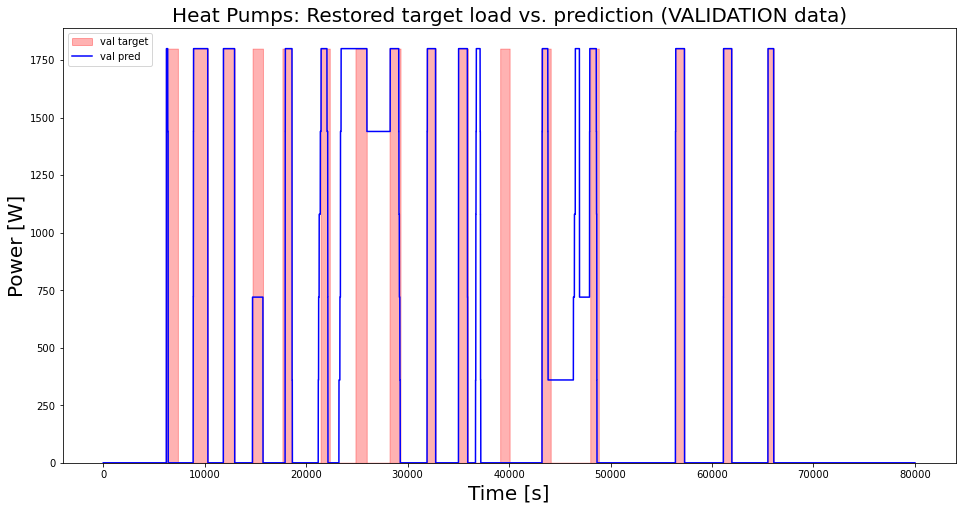

In [239]:
# Plot restored target load for heat pumps (aggregated) vs. restored prediction on VALIDATION data
# from 1st sample for house1:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(range(len(val_target_plain_load_all[:80000,0])), val_target_plain_load_all[:80000,0], color="red", alpha=0.3, labels=['val target'])
ax.plot(val_pred_plain_load_mean[:80000], color="blue", label='val pred')
plt.legend(loc='upper left')
plt.title('Heat Pumps: Restored target load vs. prediction (VALIDATION data)', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

Text(0, 0.5, 'Power [W]')

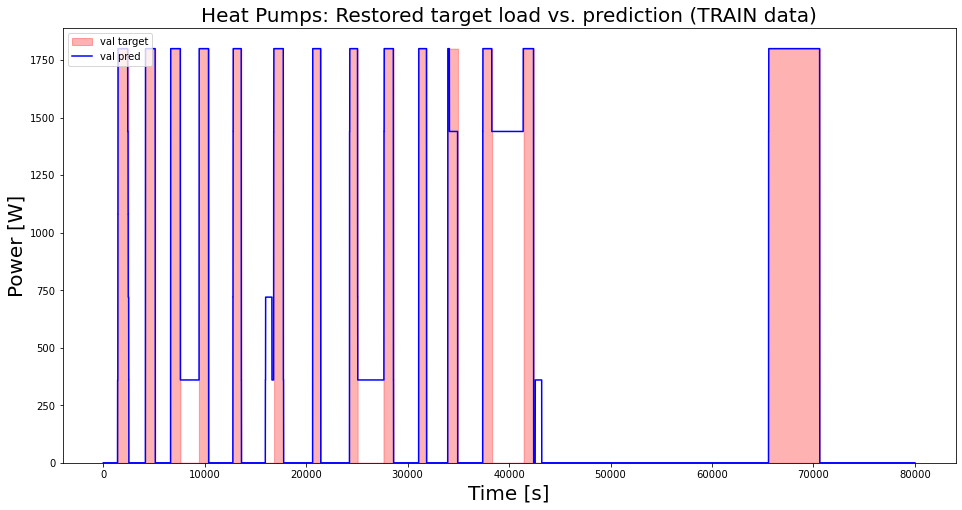

In [242]:
# Plot restored target load for heat pumps (aggregated) vs. restored prediction on TRAIN data
# from 1st sample for house1:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(range(len(train_target_plain_load_all[38000:118000,0])), train_target_plain_load_all[38000:118000,0], color="red", alpha=0.3, labels=['val target'])
ax.plot(train_pred_plain_load_mean[38000:118000], color="blue", label='val pred')
plt.legend(loc='upper left')
plt.title('Heat Pumps: Restored target load vs. prediction (TRAIN data)', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

In [219]:
len(val_target_plain_load_all)

155400

In [224]:
len(val_target_plain_load)

155400

In [113]:
## In our sliding window approach we have input_length overlapping samples for each time step.
## Optionally only pick every step_size's target, to reduce overlap.
## step_size = input_length would completely avoid overlap.
## step_size = 1 leads to maximum overlap.

# Specify step_size:
step_size = 1

# Pick only every step_size's target:
val_target_plain = val_target[np.arange(0,len(val_target),int(step_size))]
val_pred_plain = val_pred[np.arange(0,len(val_pred),int(step_size))]
train_target_plain = train_target[np.arange(0,len(train_target),int(step_size))]
train_pred_plain = train_pred[np.arange(0,len(train_pred),int(step_size))]

# Check dimensions and number of events:
print("step_size: ", step_size)
print("\nval_target shape: ", val_target_plain.shape)
print("val_pred shape: ", val_pred_plain.shape)
print("val_target: number of ON switching events: ", np.sum((val_target_plain[:,0]!=0)))
print("val_target: number of OFF switching events: ", np.sum((val_target_plain[:,1]!=0)))
print("val_pred: number of ON switching events: ", np.sum((val_pred_plain[:,0]!=0)))
print("val_pred: number of OFF switching events: ", np.sum((val_pred_plain[:,1]!=0)))

print("\ntrain_target shape: ", train_target_plain.shape)
print("train_pred shape: ", train_pred_plain.shape)
print("train_target: number of ON switching events: ", np.sum((train_target_plain[:,0]!=0)))
print("train_target: number of OFF switching events: ", np.sum((train_target_plain[:,1]!=0)))
print("train_pred: number of ON switching events: ", np.sum((train_pred_plain[:,0]!=0)))
print("train_pred: number of OFF switching events: ", np.sum((train_pred_plain[:,1]!=0)))

step_size:  1

val_target shape:  (155381, 2)
val_pred shape:  (155381, 2)
val_target: number of ON switching events:  21000
val_target: number of OFF switching events:  21700
val_pred: number of ON switching events:  25607
val_pred: number of OFF switching events:  24651

train_target shape:  (621520, 2)
train_pred shape:  (621520, 2)
train_target: number of ON switching events:  48300
train_target: number of OFF switching events:  47600
train_pred: number of ON switching events:  54806
train_pred: number of OFF switching events:  51336


In [169]:
### Restore appliance's power load from plain targets and predictions.
### Have start and end time as rel. position in sample.
### Range is supposed to be in [0, 1], where 0 means NO switching event, 0.5 means event in the middle of the sample
### and 1.0 means event at the very end of the sample.
### However, prediction values can exceed upper limit, need to take care of that by minimizing, to stay inside
### the time line at the end.

## First restore start and end times as absolute times, hence as time step in whole time line.
## Note: Length of whole time line needs to be number of samples plus input_length minus 1.
val_timeline = len(val_target_plain) + input_length - 1

# Initialize storage (number of samples):
val_target_start_restored = np.zeros(len(val_target_plain))
val_target_end_restored = np.zeros(len(val_target_plain))
val_pred_start_restored = np.zeros(len(val_pred_plain))
val_pred_end_restored = np.zeros(len(val_pred_plain))

# VALIDATION TARGET

# Loop over target samples:
for i in range(len(val_target_plain)):
    
    # Check for non-zero start time in current sample:
    if val_target_plain[i,0] != 0:
        
        # Store absolute position in time line, considering specified step_size and make sure to stay INSIDE time line.
        val_target_start_restored[i] = np.min([i * step_size + int(val_target_plain[i,0] * input_length), val_timeline])
    
    # Check for non-zero end time in current sample:
    if val_target_plain[i,1] != 0:
        
        # Store absolute position in time line, considering specified step_size and make sure to stay INSIDE time line.
        val_target_end_restored[i] = np.min([i * step_size + int(val_target_plain[i,1] * input_length), val_timeline])


# VALIDATION PRED

# Loop over pred samples:
for i in range(len(val_pred_plain)):
    
    # Check for non-zero start time in current sample:
    if val_pred_plain[i,0] != 0:
        
        # Store absolute position in time line, considering specified step_size and make sure to stay INSIDE time line.
        val_pred_start_restored[i] = np.min([i * step_size + int(val_pred_plain[i,0] * input_length), val_timeline])
    
    # Check for non-zero end time in current sample:
    if val_pred_plain[i,1] != 0:
        
        # Store absolute position in time line, considering specified step_size and make sure to stay INSIDE time line.
        val_pred_end_restored[i] = np.min([i * step_size + int(val_pred_plain[i,1] * input_length), val_timeline])
    

In [170]:
sum(val_pred_end_restored != 0)

24651

In [167]:
## VALIDATION TARGET

# Initialize storage for combined ON (=1) / OFF (=-1) switching events over whole time line:
val_target_ON_OFF_restored = np.zeros(val_timeline)

# Loop over restored start and end times:
for i in range(len(val_target_start_restored)):
    
    # Check for non-zero start time and set ON switching (= 1):
    if val_target_start_restored[i] != 0:
        val_target_ON_OFF_restored[int(val_target_start_restored[i]) - 1] = 1

In [168]:
sum(val_target_ON_OFF_restored == 1)

60

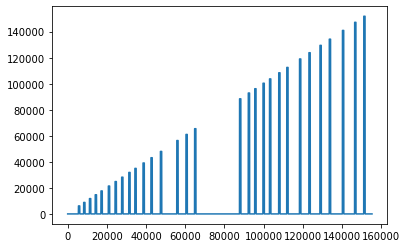

In [138]:
plt.plot(val_target_start_restored)

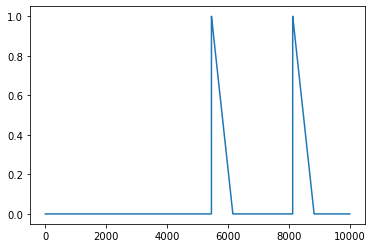

In [134]:
plt.plot(val_target_plain[:10000,0])

In [152]:
## VALIDATION TARGET

# Initialize storage for combined ON (=1) / OFF (=-1) switching events over whole time line:
val_target_ON_OFF_restored = np.zeros(val_timeline)

# Loop over restored start and end times:
for i in range(len(val_target_start_restored)):
    
    # Check for non-zero start time and set ON switching (= 1):
    if val_target_start_restored[i] != 0:
        val_target_ON_OFF_restored[int(val_target_start_restored[i])] = 1

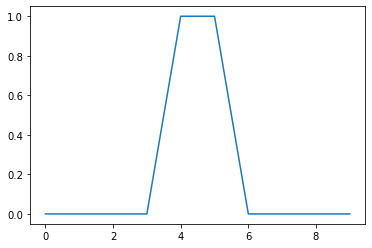

In [153]:
plt.plot((val_target_ON_OFF_restored == 1).astype(int)[6150:6160])

In [159]:
val_target_start_restored[5000:6000]

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,

In [163]:
val_target_plain[5500:6000,0] * input_length


array([655., 654., 653., 652., 651., 650., 649., 648., 647., 646., 645.,
       644., 643., 642., 641., 640., 639., 638., 637., 636., 635., 634.,
       633., 632., 631., 630., 629., 628., 627., 626., 625., 624., 623.,
       622., 621., 620., 619., 618., 617., 616., 615., 614., 613., 612.,
       611., 610., 609., 608., 607., 606., 605., 604., 603., 602., 601.,
       600., 599., 598., 597., 596., 595., 594., 593., 592., 591., 590.,
       589., 588., 587., 586., 585., 584., 583., 582., 581., 580., 579.,
       578., 577., 576., 575., 574., 573., 572., 571., 570., 569., 568.,
       567., 566., 565., 564., 563., 562., 561., 560., 559., 558., 557.,
       556., 555., 554., 553., 552., 551., 550., 549., 548., 547., 546.,
       545., 544., 543., 542., 541., 540., 539., 538., 537., 536., 535.,
       534., 533., 532., 531., 530., 529., 528., 527., 526., 525., 524.,
       523., 522., 521., 520., 519., 518., 517., 516., 515., 514., 513.,
       512., 511., 510., 509., 508., 507., 506., 50

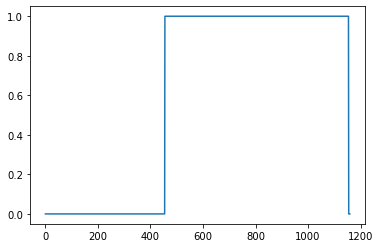

In [155]:
plt.plot((val_target_start_restored != 0).astype(int)[5000:6160])

In [141]:
sum(val_target_ON_OFF_restored == 1)

60

In [171]:
## VALIDATION TARGET

# Initialize storage for combined ON (=1) / OFF (=-1) switching events over whole time line:
val_target_ON_OFF_restored = np.zeros(val_timeline)

# Loop over restored start and end times:
for i in range(len(val_target_start_restored)):
    
    # Check for non-zero start time and set ON switching (= 1):
    if val_target_start_restored[i] != 0:
        val_target_ON_OFF_restored[int(val_target_start_restored[i]) - 1] = 1
        
    # Check for non-zero end time and set OFF switching (= -1):
    if val_target_end_restored[i] != 0:
        val_target_ON_OFF_restored[int(val_target_end_restored[i]) - 1] = -1


## VALIDATION PRED

# Initialize storage for combined ON (=1) / OFF (=-1) switching events over whole time line:
val_pred_ON_OFF_restored = np.zeros(val_timeline)

# Loop over restored start and end times:
for i in range(len(val_pred_start_restored)):
    
    # Check for non-zero start time and set ON switching (= 1):
    if val_pred_start_restored[i] != 0:
        val_pred_ON_OFF_restored[int(val_pred_start_restored[i]) - 1] = 1
        
    # Check for non-zero end time and set OFF switching (= -1):
    if val_pred_end_restored[i] != 0:
        val_pred_ON_OFF_restored[int(val_pred_end_restored[i]) - 1] = -1

In [175]:
sum(val_target_ON_OFF_restored == -1)

62

In [176]:
## Now run over switching events and restore mean load:

## VALIDATION TARGET

# Initialize storage for mean load:
val_target_mean_load_restored = np.zeros(val_timeline)

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(val_target_ON_OFF_restored)):
    
    # First time step:
    if i == 0:
        val_target_mean_load_restored[i] = np.max([0, val_target_ON_OFF_restored[i]])
    else:
        val_target_mean_load_restored[i] = np.min([1, np.max([0, val_target_mean_load_restored[i-1] + val_target_ON_OFF_restored[i]])])

# And finally multiply load series with target1_mean_load:
val_target_mean_load_restored = val_target_mean_load_restored * target1_mean_load


## VALIDATION PRED

# Initialize storage for mean load:
val_pred_mean_load_restored = np.zeros(val_timeline)

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(val_pred_ON_OFF_restored)):
    
    # First time step:
    if i == 0:
        val_pred_mean_load_restored[i] = np.max([0, val_pred_ON_OFF_restored[i]])
    else:
        val_pred_mean_load_restored[i] = np.min([1, np.max([0, val_pred_mean_load_restored[i-1] + val_pred_ON_OFF_restored[i]])])

# And finally multiply load series with target1_mean_load:
val_pred_mean_load_restored = val_pred_mean_load_restored * target1_mean_load

In [110]:
sum(val_target_ON_OFF_restored<0)

62

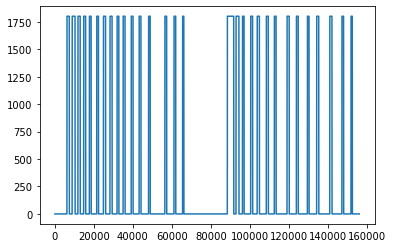

In [181]:
plt.plot(val_target_mean_load_restored)

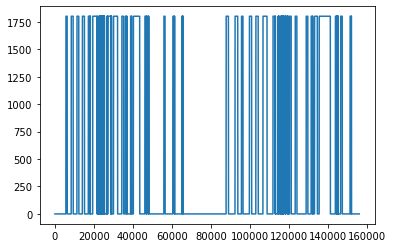

In [182]:
plt.plot(val_pred_mean_load_restored)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Power [W]')

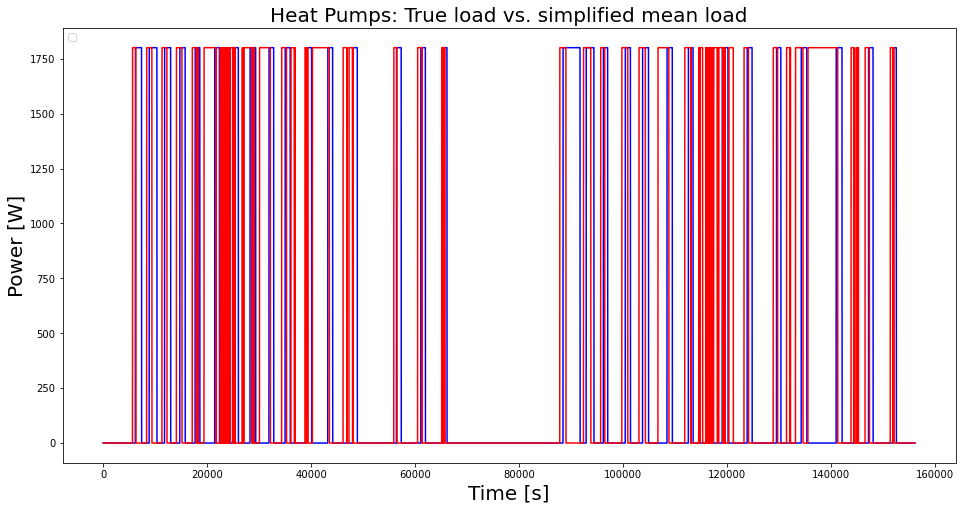

In [184]:
# Plot true load for heat pumps (aggregated) vs. restored mean load for
# first ON phases from 1st sample for house1:
fig, ax = plt.subplots(figsize=(16, 8))
#ax.plot(target1_mean_load_series[-len(val_target_load_restored_mean):-len(val_target_load_restored_mean)+30000], color="blue")
ax.plot(val_target_mean_load_restored, color="blue")
ax.plot(val_pred_mean_load_restored, color="red")
#ax.stackplot(range(30000), val_pred_mean_load_restored[:30000], color="red")
plt.legend(loc='upper left')
plt.title('Heat Pumps: True load vs. simplified mean load', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

In [88]:
sum(val_pred_start_restored!=0)

25607

In [91]:
val_pred_start_restored[val_pred_start_restored!=0].shape

(25607,)

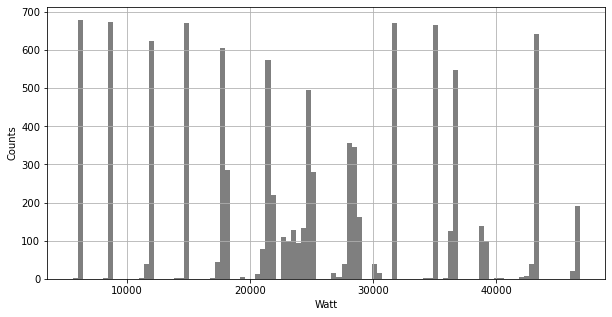

In [119]:
# Plot histogram for i-th submeter
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(val_pred_start_restored[val_pred_start_restored!=0][:10000], nBins, color="black", alpha=0.5)
axes.grid()
axes.set_xlabel("Watt")
axes.set_ylabel("Counts")
plt.show()

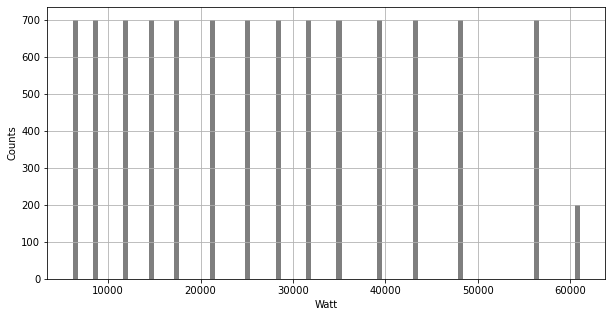

In [120]:
# Plot histogram for i-th submeter
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(val_target_start_restored[val_target_start_restored!=0][:10000], nBins, color="black", alpha=0.5)
axes.grid()
axes.set_xlabel("Watt")
axes.set_ylabel("Counts")
plt.show()

In [74]:
### Have start and end time as absolute position in time line in where 0 means NO switching event.
### Now create load over whole time line for each sample.

## The following cases need to be treated seperately:
# 1) Both - start AND end time - equal to zero: ZERO load for whole TIME LINE.
# 2a) Only START time non-zero: ZERO load up to start time, then take mean load for the rest of the TIME LINE.
# 2b) Only END time non-zero: Take ZERO load up to end time, then take neg. mean load for the rest of TIME LINE.
# 3) Both - start AND end time - non-zero: Depends on what comes first. If start time < end time of vice versa.

## VALIDATION TARGET

# Initialize storage to combine positive and negative loads (length of time line):
val_target_load_restored = np.zeros(val_timeline)

# Number of non-zero start and end times, needed for normalization:
val_target_starttimes = sum(val_target_start_restored != 0)
val_target_endtimes = sum(val_target_end_restored != 0)

# Loop over samples:
for i in range(len(val_target_plain)):

    # Initialize temporal storage (length of time line):
    temp_pos_storage = np.zeros(val_timeline)
    temp_neg_storage = np.zeros(val_timeline)

    # Check for non-zero START time:
    if val_target_start_restored[i] != 0:
        
        # ZERO load up to start time, then take mean load for the rest of the TIME LINE.
        temp_pos_storage[int(val_target_start_restored[i]):val_timeline] = target1_mean_load
        
        # Add positive load to combined load:
        val_target_load_restored += temp_pos_storage 
        
    # Check for non-zero END time:
    if val_target_end_restored[i] != 0:
        
        # Take mean load up to end time, then ZERO load for the rest of TIME LINE.
        temp_neg_storage[:int(val_target_end_restored[i])] = target1_mean_load
        
        # Add negative load to combined load:
        val_target_load_restored += temp_neg_storage

# Normalize restored load:
#val_target_load_restored = val_target_load_restored / (val_target_starttimes + val_target_endtimes) * 2

In [69]:
## VALIDATION PRED

# Initialize storage to combine positive and negative loads (length of time line):
val_pred_load_restored = np.zeros(val_timeline)

# Number of non-zero start and end times, needed for normalization:
val_pred_starttimes = sum(val_pred_start_restored != 0)
val_pred_endtimes = sum(val_pred_end_restored != 0)

# Loop over samples:
for i in range(len(val_pred_plain)):

    # Initialize temporal storage (length of time line):
    temp_pos_storage = np.zeros(val_timeline)
    temp_neg_storage = np.zeros(val_timeline)

    # Check for non-zero START time:
    if val_pred_start_restored[i] != 0:
        
        # ZERO load up to start time, then take mean load for the rest of the TIME LINE.
        temp_pos_storage[int(val_pred_start_restored[i]):val_timeline] = target1_mean_load
        
        # Add positive load to combined load:
        val_pred_load_restored += temp_pos_storage 
        
    # Check for non-zero END time:
    if val_pred_end_restored[i] != 0:
        
        # Take mean load up to end time, then ZERO load for the rest of TIME LINE.
        temp_neg_storage[:int(val_pred_end_restored[i])] = target1_mean_load
        
        # Add negative load to combined load:
        val_pred_load_restored += temp_neg_storage

# Normalize restored load:
val_pred_load_restored = val_pred_load_restored / (val_pred_starttimes + val_pred_endtimes) * 2

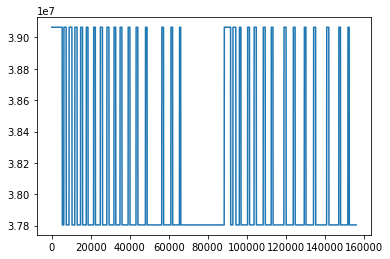

In [75]:
plt.plot(val_target_load_restored)

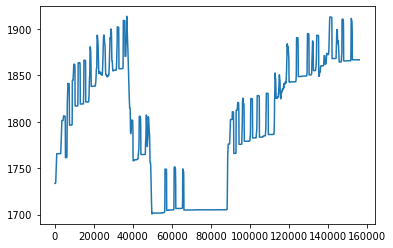

In [71]:
plt.plot(val_pred_load_restored)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Power [W]')

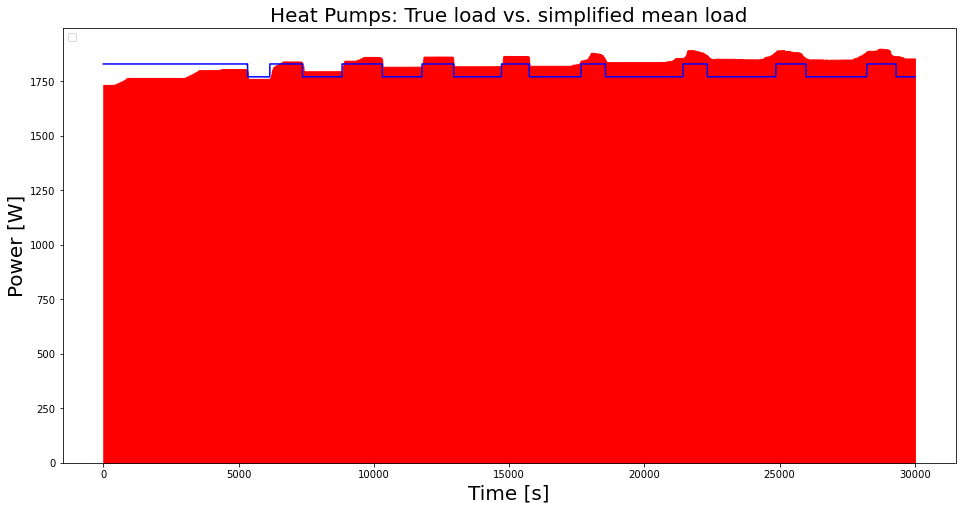

In [73]:
# Plot true load for heat pumps (aggregated) vs. restored mean load for
# first ON phases from 1st sample for house1:
fig, ax = plt.subplots(figsize=(16, 8))
#ax.plot(target1_mean_load_series[-len(val_target_load_restored_mean):-len(val_target_load_restored_mean)+30000], color="blue")
ax.plot(val_target_load_restored[:30000], color="blue")
ax.stackplot(range(30000), val_pred_load_restored[:30000], color="red")
plt.legend(loc='upper left')
plt.title('Heat Pumps: True load vs. simplified mean load', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

In [57]:
### Restore appliance's power load from plain targets and predictions:

## First restore start and end times as absolute times in sample:

## Validation data:

# Check start and end time, given as relative position in sample. 
# Need to multiply start and end time, given as relative position in sample, with input_length,
# to restore absolute position.
val_target_start_restored = (val_target[:,0] * input_length).astype(int)
val_target_end_restored = (val_target[:,1] * input_length).astype(int)

## For predictions need to force start and end time to be within input_length by minimizing!

# Initialize storage:
val_pred_start_restored = (val_pred[:,0] * input_length).astype(int)
val_pred_end_restored = (val_pred[:,1] * input_length).astype(int)

# Loop over samples:
for i in range(len(val_pred)):
    # Minimize with input_length
    val_pred_start_restored[i] = np.min([val_pred_start_restored[i], input_length])
    val_pred_end_restored[i] = np.min([val_pred_end_restored[i], input_length])
    
## Training data:

# Check start and end time, given as relative position in sample. 
# Need to multiply start and end time, given as relative position in sample, with input_length,
# to restore absolute position.
train_target_start_restored = (train_target[:,0] * input_length).astype(int)
train_target_end_restored = (train_target[:,1] * input_length).astype(int)

## For predictions need to force start and end time to be within input_length by minimizing!

# Initialize storage:
train_pred_start_restored = (train_pred[:,0] * input_length).astype(int)
train_pred_end_restored = (train_pred[:,1] * input_length).astype(int)

# Loop over samples:
for i in range(len(train_pred)):
    # Minimize with input_length
    train_pred_start_restored[i] = np.min([train_pred_start_restored[i], input_length])
    train_pred_end_restored[i] = np.min([train_pred_end_restored[i], input_length])

In [58]:
## Check for switching events: 
# How often are both - start AND end time - equal to zero?
# How often do we only have non-zero start OR end time?
# And how often do we have both - start AND end time - to be non-zero?
print("Total number of VALIDATION prediction samples: ", len(val_pred))
print("\nBoth - start AND end time - equal to zero: ", np.sum((val_pred_start_restored==0) & (val_pred_end_restored==0)))
print("Only START time non-zero: ", np.sum(val_pred_start_restored!=0))
print("Only END time non-zero: ", np.sum(val_pred_end_restored!=0))
print("Both - start AND end time - non-zero: ", np.sum((val_pred_start_restored!=0) & (val_pred_end_restored!=0)))
print("\n\nTotal number of TRAIN prediction samples: ", len(train_pred))
print("\nBoth - start AND end time - equal to zero: ", np.sum((train_pred_start_restored==0) & (train_pred_end_restored==0)))
print("Only START time non-zero: ", np.sum(train_pred_start_restored!=0))
print("Only END time non-zero: ", np.sum(train_pred_end_restored!=0))
print("Both - start AND end time - non-zero: ", np.sum((train_pred_start_restored!=0) & (train_pred_end_restored!=0)))

# Note: These numbers do not match the number of switching events stated above, since HERE we convert absolute
# predictions to integer, which forces some non-zero predictions to ZERO.

Total number of VALIDATION prediction samples:  155381

Both - start AND end time - equal to zero:  110930
Only START time non-zero:  23199
Only END time non-zero:  21326
Both - start AND end time - non-zero:  74


Total number of TRAIN prediction samples:  621520

Both - start AND end time - equal to zero:  526704
Only START time non-zero:  47322
Only END time non-zero:  47499
Both - start AND end time - non-zero:  5


In [ ]:
### Then restore power load from restored start and end times.
### Have start and end time as absolute position in sample in [0, input_length], where 0 means NO switching event.

## The following cases need to be treated seperately:
# 1) Both - start AND end time - equal to zero: ZERO load for sample.
# 2a) Only START time non-zero: ZERO load up to start time, then take mean load for the rest of the TIME LINE.
# 2b) Only END time non-zero: Take ZERO load up to end time, then take neg. mean load for the rest of TIME LINE.
# 3) Both - start AND end time - non-zero: Depends on what comes first. If start time < end time of vice versa.


### Validation data:

# Initialize storage:
val_target_load_restored = np.zeros((len(val_target), input_length))
val_pred_load_restored = np.zeros((len(val_pred), input_length))

## Validation Target

# Loop over validation samples:
for i in range(len(val_target)):
    
    # Case 1) Both - start AND end time - equal to zero: ZERO load for sample. --> Nothing to do!
    # Other cases:
    if (val_target_start_restored[i] != 0) | (val_target_end_restored[i] != 0):
                      
        # Case 2a) Only START time non-zero, hence END time equal to ZERO: 
        if val_target_end_restored[i] == 0:
            
            # Loop over sample:
            for j in range(input_length):
                
                # ZERO load up to start time, then take mean load for the rest of the sample.
                if j >= (val_target_start_restored[i] - 1):
                    
                    # Set restored load to mean load:
                    val_target_load_restored[i,j] = target1_mean_load
                    
        # Case 2b) Only END time non-zero, hence START time equal to ZERO: 
        elif val_target_start_restored[i] == 0:
            
            # Loop over sample:
            for j in range(input_length):
                
                # Take mean load up to end time, then take ZERO load for the rest of the sample.
                if j <= (val_target_end_restored[i] - 1):
                    
                    # Set restored load to mean load:
                    val_target_load_restored[i,j] = target1_mean_load
                    
        # Case 3) ADD later, ignore for now!

## Validation Predictions
        
# Loop over validation samples:
for i in range(len(val_pred)):
    
    # Case 1) Both - start AND end time - equal to zero: ZERO load for sample. --> Nothing to do!
    # Other cases:
    if (val_pred_start_restored[i] != 0) | (val_pred_end_restored[i] != 0):
                      
        # Case 2a) Only START time non-zero, hence END time equal to ZERO: 
        if val_pred_end_restored[i] == 0:
            
            # Loop over sample:
            for j in range(input_length):
                
                # ZERO load up to start time, then take mean load for the rest of the sample.
                if j >= (val_pred_start_restored[i] - 1):
                    
                    # Set restored load to mean load:
                    val_pred_load_restored[i,j] = target1_mean_load
                    
        # Case 2b) Only END time non-zero, hence START time equal to ZERO: 
        elif val_pred_start_restored[i] == 0:
            
            # Loop over sample:
            for j in range(input_length):
                
                # Take mean load up to end time, then take ZERO load for the rest of the sample.
                if j <= (val_pred_end_restored[i] - 1):
                    
                    # Set restored load to mean load:
                    val_pred_load_restored[i,j] = target1_mean_load
                    
        # Case 3) ADD later, ignore for now!

# ADD train_target and train_pred

In [82]:
### Then restore power load from restored start and end times.
### Have start and end time as absolute position in sample in [0, input_length], where 0 means NO switching event.

## The following cases need to be treated seperately:
# 1) Both - start AND end time - equal to zero: ZERO load for sample.
# 2a) Only START time non-zero: ZERO load up to start time, then take mean load for the rest of the sample.
# 2b) Only END time non-zero: Take mean load up to end time, then take ZERO load for the rest of the sample.
# 3) Both - start AND end time - non-zero: Depends on what comes first. If start time < end time of vice versa.


### Validation data:

# Initialize storage:
val_target_load_restored = np.zeros((len(val_target), input_length))
val_pred_load_restored = np.zeros((len(val_pred), input_length))

## Validation Target

# Loop over validation samples:
for i in range(len(val_target)):
    
    # Case 1) Both - start AND end time - equal to zero: ZERO load for sample. --> Nothing to do!
    # Other cases:
    if (val_target_start_restored[i] != 0) | (val_target_end_restored[i] != 0):
                      
        # Case 2a) Only START time non-zero, hence END time equal to ZERO: 
        if val_target_end_restored[i] == 0:
            
            # Loop over sample:
            for j in range(input_length):
                
                # ZERO load up to start time, then take mean load for the rest of the sample.
                if j >= (val_target_start_restored[i] - 1):
                    
                    # Set restored load to mean load:
                    val_target_load_restored[i,j] = target1_mean_load
                    
        # Case 2b) Only END time non-zero, hence START time equal to ZERO: 
        elif val_target_start_restored[i] == 0:
            
            # Loop over sample:
            for j in range(input_length):
                
                # Take mean load up to end time, then take ZERO load for the rest of the sample.
                if j <= (val_target_end_restored[i] - 1):
                    
                    # Set restored load to mean load:
                    val_target_load_restored[i,j] = target1_mean_load
                    
        # Case 3) ADD later, ignore for now!

## Validation Predictions
        
# Loop over validation samples:
for i in range(len(val_pred)):
    
    # Case 1) Both - start AND end time - equal to zero: ZERO load for sample. --> Nothing to do!
    # Other cases:
    if (val_pred_start_restored[i] != 0) | (val_pred_end_restored[i] != 0):
                      
        # Case 2a) Only START time non-zero, hence END time equal to ZERO: 
        if val_pred_end_restored[i] == 0:
            
            # Loop over sample:
            for j in range(input_length):
                
                # ZERO load up to start time, then take mean load for the rest of the sample.
                if j >= (val_pred_start_restored[i] - 1):
                    
                    # Set restored load to mean load:
                    val_pred_load_restored[i,j] = target1_mean_load
                    
        # Case 2b) Only END time non-zero, hence START time equal to ZERO: 
        elif val_pred_start_restored[i] == 0:
            
            # Loop over sample:
            for j in range(input_length):
                
                # Take mean load up to end time, then take ZERO load for the rest of the sample.
                if j <= (val_pred_end_restored[i] - 1):
                    
                    # Set restored load to mean load:
                    val_pred_load_restored[i,j] = target1_mean_load
                    
        # Case 3) ADD later, ignore for now!

# ADD train_target and train_pred

In [84]:
## Now have overlapping samples and but want to restore SINGLE time line:

# Initialize storage: Length needs to be number of samples plus input_length minus 1
val_target_load_restored_mean = np.zeros(len(val_target_load_restored) + input_length - 1)
val_pred_load_restored_mean = np.zeros(len(val_pred_load_restored) + input_length - 1)

## Initialize storage for divisor, used later: Just count the number of non-zero contributions in time line:
val_target_nonzero_contrib = (val_target_load_restored > 0).astype(int)
val_pred_nonzero_contrib = (val_pred_load_restored > 0).astype(int)
val_target_divisor = np.zeros(len(val_target_load_restored) + input_length - 1)
val_pred_divisor = np.zeros(len(val_pred_load_restored) + input_length - 1)

# Loop over samples:
for i in range(len(val_target_load_restored)):
    
    # First naively add mean loads, but put it on the correct position of the time line:
    val_target_load_restored_mean[i:i+input_length] += val_target_load_restored[i]
    val_pred_load_restored_mean[i:i+input_length] += val_pred_load_restored[i]

    # And count number of non-zero contributions to obtain divisor:
    val_target_divisor[i:i+input_length] += val_target_nonzero_contrib[i]
    val_pred_divisor[i:i+input_length] += val_pred_nonzero_contrib[i]

In [ ]:
## Then divide restored mean load by the number of non-zero contributions (= divisor):

# Loop over time line:
for j in range(len(val_target_load_restored_mean)):
    
    # Then divide restored mean load by the number of non-zero contributions, avoid dividion by zero!
    if val_target_divisor[j] != 0:
        val_target_load_restored_mean[j] = val_target_load_restored_mean[j] / val_target_divisor[j]

    if val_pred_divisor[j] != 0:
        val_pred_load_restored_mean[j] = val_pred_load_restored_mean[j] / val_pred_divisor[j]

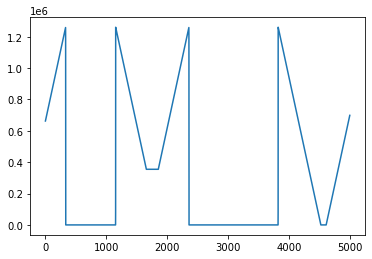

In [85]:
plt.plot(val_target_load_restored_mean[5000:10000])

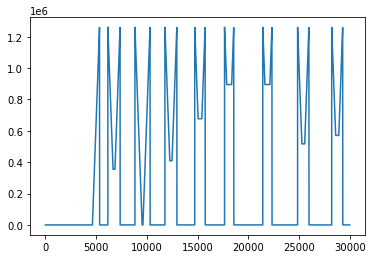

In [86]:
plt.plot(val_target_load_restored_mean[:30000])

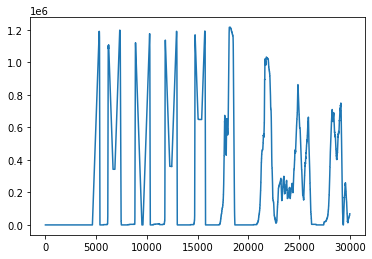

In [87]:
plt.plot(val_pred_load_restored_mean[:30000])

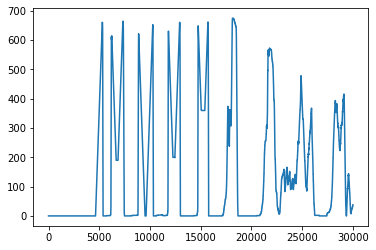

In [91]:
plt.plot(val_pred_divisor[:30000])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Power [W]')

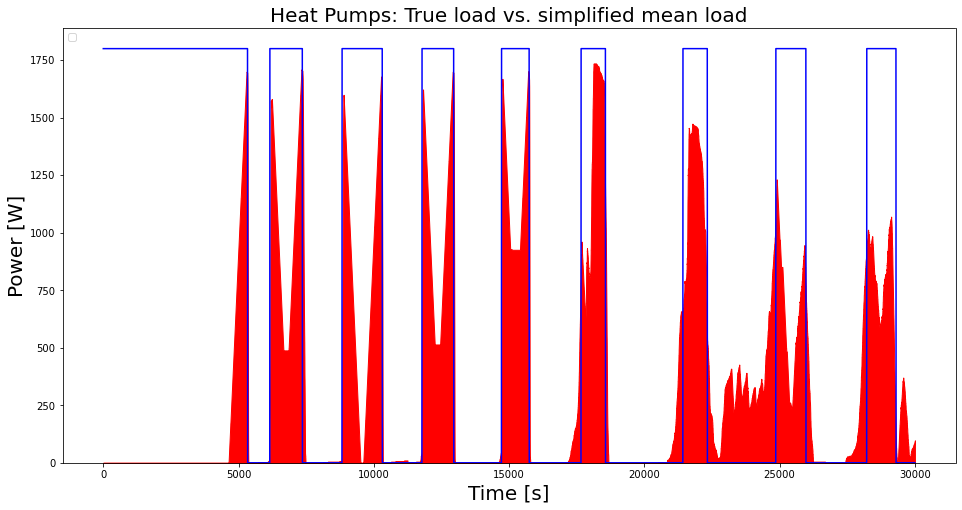

In [92]:
# Plot true load for heat pumps (aggregated) vs. restored mean load for
# first ON phases from 1st sample for house1:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(target1_mean_load_series[-len(val_target_load_restored_mean):-len(val_target_load_restored_mean)+30000], color="blue")
#ax.plot(val_target_load_restored_mean[:30000], color="blue")
ax.stackplot(range(30000), val_pred_load_restored_mean[:30000]/input_length, color="red")
plt.legend(loc='upper left')
plt.title('Heat Pumps: True load vs. simplified mean load', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

In [ ]:



# Need to multiply start and end time, given as relative position in sample, with input_length,
# to restore absolute position.
val_target_start_restored = (val_target[:,0] * input_length).astype(int)
val_target_end_restored = (val_target[:,1] * input_length).astype(int)

## For predictions need to force start and end time to be within input_length by minimizing!

# Initialize storage:
val_pred_start_restored = (val_pred[:,0] * input_length).astype(int)
val_pred_end_restored = (val_pred[:,1] * input_length).astype(int)

# Loop over samples:
for i in range(len(val_pred)):
    # Minimize with input_length
    val_pred_start_restored[i] = np.min([val_pred_start_restored[i], input_length])

In [66]:
### Then restore power load from restored start and end times:


## Val Target:

# Combine start and end times to one series containing switching events: ON = 1, OFF = -1
val_target_plain_ON_OFF = val_target_plain_start - val_target_plain_end

# Initialize storage:
val_target_plain_load = np.zeros((len(val_target_plain), input_length))

In [59]:
# Loop over plain target combined start and end times:
for i in range(len(val_target_plain_ON_OFF)):

    
    
    # Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
    for i in range(len(val_target_plain_ON_OFF)):

        # First time step:
        if i == 0:
            val_target_plain_load[i] = np.max([0, val_target_plain_ON_OFF[i]])
        else:
            val_target_plain_load[i] = np.min([1, np.max([0, val_target_plain_load[i-1] + val_target_plain_ON_OFF[i]])])

# And finally multiply load series with target1_mean_load:
val_target_plain_load = val_target_plain_load * target1_mean_load


## Val Pred:

# Combine start and end times to one series containing switching events: ON = 1, OFF = -1
val_pred_plain_ON_OFF = val_pred_plain_start - val_pred_plain_end

# Initialize storage:
val_pred_plain_load = np.zeros((len(val_pred_plain), input_length))

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(val_pred_plain_ON_OFF)):
    
    # First time step:
    if i == 0:
        val_pred_plain_load[i] = np.max([0, val_pred_plain_ON_OFF[i]])
    else:
        val_pred_plain_load[i] = np.min([1, np.max([0, val_pred_plain_load[i-1] + val_pred_plain_ON_OFF[i]])])

# And finally multiply load series with target1_mean_load:
val_pred_plain_load = val_pred_plain_load * target1_mean_load


## Train Target:

# Combine start and end times to one series containing switching events: ON = 1, OFF = -1
train_target_plain_ON_OFF = train_target_plain_start - train_target_plain_end

# Initialize storage:
train_target_plain_load = np.zeros(len(train_target_plain) * input_length)

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(train_target_plain_ON_OFF)):
    
    # First time step:
    if i == 0:
        train_target_plain_load[i] = np.max([0, train_target_plain_ON_OFF[i]])
    else:
        train_target_plain_load[i] = np.min([1, np.max([0, train_target_plain_load[i-1] + train_target_plain_ON_OFF[i]])])

# And finally multiply load series with target1_mean_load:
train_target_plain_load = train_target_plain_load * target1_mean_load


## Train Pred:

# Combine start and end times to one series containing switching events: ON = 1, OFF = -1
train_pred_plain_ON_OFF = train_pred_plain_start - train_pred_plain_end

# Initialize storage:
train_pred_plain_load = np.zeros(len(train_pred_plain) * input_length)

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(train_pred_plain_ON_OFF)):
    
    # First time step:
    if i == 0:
        train_pred_plain_load[i] = np.max([0, train_pred_plain_ON_OFF[i]])
    else:
        train_pred_plain_load[i] = np.min([1, np.max([0, train_pred_plain_load[i-1] + train_pred_plain_ON_OFF[i]])])

# And finally multiply load series with target1_mean_load:
train_pred_plain_load = train_pred_plain_load * target1_mean_load

Text(0, 0.5, 'Power [W]')

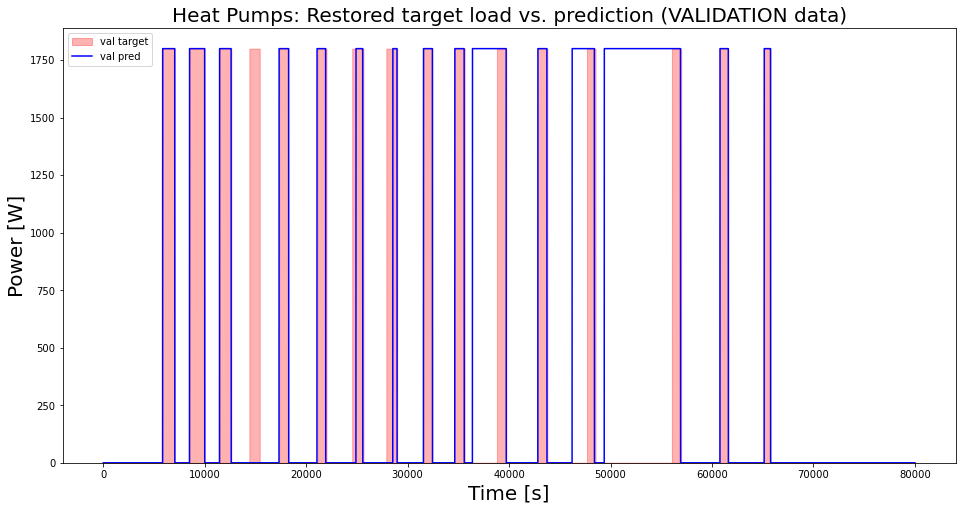

In [60]:
# Plot restored target load for heat pumps (aggregated) vs. restored prediction on VALIDATION data
# from 1st sample for house1:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(range(len(val_target_plain_load[:80000])), val_target_plain_load[:80000], color="red", alpha=0.3, labels=['val target'])
ax.plot(val_pred_plain_load[:80000], color="blue", label='val pred')
plt.legend(loc='upper left')
plt.title('Heat Pumps: Restored target load vs. prediction (VALIDATION data)', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

Text(0, 0.5, 'Power [W]')

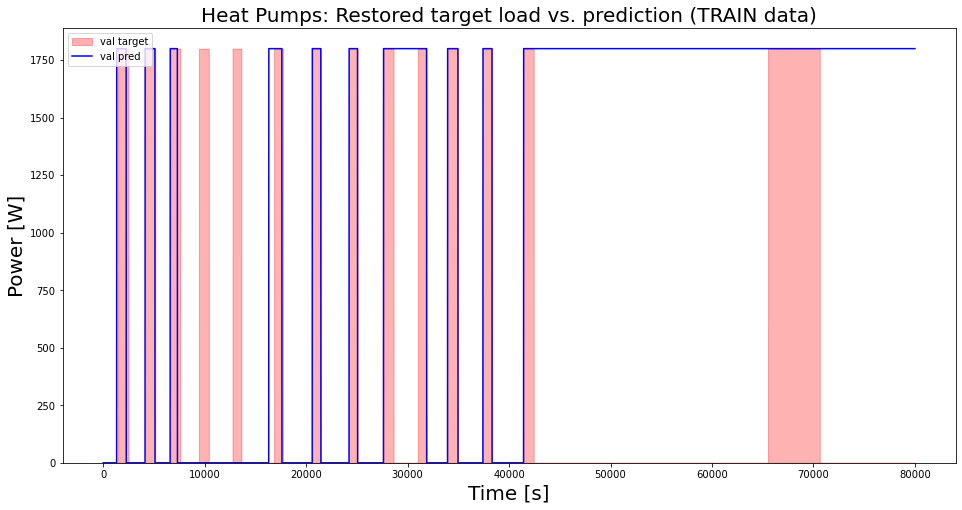

In [61]:
# Plot restored target load for heat pumps (aggregated) vs. restored prediction on TRAIN data
# from 1st sample for house1:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(range(len(train_target_plain_load[38000:118000])), train_target_plain_load[38000:118000], color="red", alpha=0.3, labels=['val target'])
ax.plot(train_pred_plain_load[38000:118000], color="blue", label='val pred')
plt.legend(loc='upper left')
plt.title('Heat Pumps: Restored target load vs. prediction (TRAIN data)', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

### Model Evaluation

[Marwah and Han, 2011] describe **Precision, Recall and F-measure** as some metrics used for evaluation of our models' performance: Let $x$ be the predicted value and $x_0$ to be the ground truth. In our case we look at power consumption of a certain appliance at a certain time step. We then need to distinguish:

$$
x=0\,\,\,AND\,\,\,x_0=0\,\,\,\,\,\,\rightarrow TN \\
x=0\,\,\,AND\,\,\,x_0>0\,\,\,\,\,\,\rightarrow FN \\
x>0\,\,\,AND\,\,\,x_0=0\,\,\,\,\,\,\rightarrow FP \\
x>0\,\,\,AND\,\,\,x_0>0\,\,\,\,\,\,\rightarrow TP 
$$

Here TN, FN, FP and TP refer to "true negative", "false negative", "false positive" and "true positive", respectively. TP is then further split into "inaccurate true positive" (ITP) and "accurate true positive" (ATP), given $\frac{|x-x_0|}{x_0}>\rho$ or $\frac{|x-x_0|}{x_0}\leq\rho$, respectively, with some threshhold $\rho=0.2$.

We then define **Precision**=$\frac{ATP}{ATP + ITP + FP}$, **Recall**=$\frac{ATP}{ATP + ITP + FN}$ and **F-measure**=$\frac{2 \cdot Precision \cdot Recall}{Precision + Recall}$.

In [62]:
# Define measures on VALIDATION data:
val_TN = sum((val_pred_plain_load == 0) & (val_target_plain_load == 0))
val_FN = sum((val_pred_plain_load == 0) & (val_target_plain_load > 0))
val_FP = sum((val_pred_plain_load > 0) & (val_target_plain_load == 0))
val_TP = sum((val_pred_plain_load > 0) & (val_target_plain_load > 0))
val_prec = val_TP / (val_TP + val_FP)
val_rec = val_TP / (val_TP + val_FN)
val_Fmeas = (2 * val_prec * val_rec) / (val_prec + val_rec)

# Define measures on TRAIN data:
train_TN = sum((train_pred_plain_load == 0) & (train_target_plain_load == 0))
train_FN = sum((train_pred_plain_load == 0) & (train_target_plain_load > 0))
train_FP = sum((train_pred_plain_load > 0) & (train_target_plain_load == 0))
train_TP = sum((train_pred_plain_load > 0) & (train_target_plain_load > 0))
train_prec = train_TP / (train_TP + train_FP)
train_rec = train_TP / (train_TP + train_FN)
train_Fmeas = (2 * train_prec * train_rec) / (train_prec + train_rec)

# Check measures:
print("train precision: ", np.round(train_prec * 100,1), "%")
print("train recall: ", np.round(train_rec * 100,1), "%")
print("train F-measure: ", np.round(train_Fmeas * 100,1), "%")
print("\nval precision: ", np.round(val_prec * 100,1), "%")
print("val recall: ", np.round(val_rec * 100,1), "%")
print("val F-measure: ", np.round(val_Fmeas * 100,1), "%")

train precision:  32.7 %
train recall:  90.2 %
train F-measure:  48.0 %

val precision:  57.1 %
val recall:  86.1 %
val F-measure:  68.6 %
